In [1]:
#Import Python Libraries
import pandas as pd
import pickle
import time
import numpy as np

#Import Self-written Functions
import os
import sys
src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)

from d00_utils.calculateTimeDifference import calculateTimeDifference #Function to calc time difference
from d01_data.loadCommits import loadCommits #Function to load SVN data
from d02_intermediate.cleanCommitData import cleanCommitData #Function to clean commit data
from d02_intermediate.cleanJiraData import cleanJiraData #Function to clean JIRA data

from d03_processing.createFittedTF_IDF import createFittedTF_IDF #Function to see if a trace is valid
from d03_processing.createCorpusFromDocumentList import createCorpusFromDocumentList #Function to create a corpus
from d03_processing.checkValidityTrace import checkValidityTrace #Function to see if a trace is valid
from d03_processing.calculateTimeDif import calculateTimeDif #Calculate the time difference between 2 dates in seconds
from d03_processing.checkFullnameEqualsEmail import checkFullnameEqualsEmail #Check if fullName is equal to the email
from d03_processing.calculateCosineSimilarity import calculateCosineSimilarity #Calculate the cos similarity
from d03_processing.calculateDocumentStatistics import calculateUniqueWordCount
from d03_processing.calculateDocumentStatistics import calculateTotalWordCount
from d03_processing.calculateDocumentStatistics import calculateOverlapBetweenDocuments

from d04_modelling.summariseClassDistribution import summariseClassDistribution #Visualize the class distribution
from d04_modelling.showModelPerformance import showModelPerformance # Show several performance measures

#Display full value of a column
pd.set_option('display.max_colwidth', None)

#Display all columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. Load Raw Data

In [2]:
#Set dataset

datasetDirectory = ""

In [3]:
#Import raw JIRA dataset
rawData_JIRA_dealService = pd.read_csv('../data/01_raw/deal-service.csv')

#import
rawData_SVN_dealService = loadCommits('../data/01_raw/dealservice-dump.txt')

# 2. Clean Raw Data
## 2.1 Clean Raw Data - SVN Data
Clean the raw data of the SVN files

In [4]:
from datetime import datetime
import re
import pandas as pd
import string

#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.util import ngrams

#Function to transform natural text into unigram tokens
def preprocessNaturalLanguage(text, porterStemmer, cachedStopWords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopWords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

#Function to transform natural text into n-gram tokens
def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_interpunction)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocessCommitDate(date_string):
    date_time_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S.%fZ')  
    return(date_time_obj)
    
#Remove the found Issue key from the log
def removeIssueKey(log_message):
    issue_keys = re.findall(r"LRN+.[0-9]+|AFM+.[0-9]+|MA+.[0-9]+|AFI+.[0-9]+|EM+.[0-9]+|OE+.[0-9]+|EM+.[0-9]+", log_message)
    log_message_without_key = log_message
    for issue_key in issue_keys:
        log_message_without_key = log_message_without_key.replace(issue_key, "")
    return(log_message_without_key)

def unitNamesLambdaFunc(unitName, stemmer):
    #Lower case
    unitNameLowered = unitName.lower()
    
    #Remove interpunction
    noInterpunction = unitNameLowered.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    noNumbers = ''.join([i for i in noInterpunction if not i.isdigit()])
    
    stemmendUnitName = stemmer.stem(noInterpunction)
    
    
    return(stemmendUnitName)
    

def preprocessUnitNames(unitName, porterStemmer, cachedStopWords):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #Preprocess each split found.
        unitNameLowered = list(map(lambda unitName: unitNamesLambdaFunc(unitName, porterStemmer), 
                                   unitNameSplitList))
        
        #Check for stopwords
        tokensWithoutSW = [word for word in unitNameLowered if not word in cachedStopWords]

        return(tokensWithoutSW)

def preprocessNGramsUnitNames(unitName, porterStemmer, cachedStopWords, nGramSize):
    if (isinstance(unitName, str)):
        #Split camelCasing
        unitNameSplitList = re.sub('([A-Z][a-z]+)', r' \1', re.sub('([A-Z]+)', r' \1', unitName)).split()
        
        cleanedUnitNames = []
        for unitNameSplit in unitNameSplitList:
            #Lower case unit names
            lowerCased = unitNameSplit.lower()

            #Remove interpunction
            removedInterpunction = lowerCased.translate(str.maketrans('','',string.punctuation))
            cleanedUnitNames.append(removedInterpunction)
            
        #Transform to string (needed for tokenizer
        unitNameString = ' '.join(cleanedUnitNames)

        #Tokenzize words
        tokenized = word_tokenize(unitNameString)
        
        #Create the ngrams
        ngrams = list(nltk.ngrams(tokenized, nGramSize))
        
        porterStemmer = PorterStemmer() #create an object of class PorterStemmer
        
        #remove all the n-grams containing a stopword
        cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
        #Stem the tokens
        stemmedNGrams = []
        for ngram in cleanNGrams:
            stemmed = list(map(porterStemmer.stem, ngram))
            stemmedNGrams.append(stemmed)
            
        return(stemmedNGrams)

#Method to clean all columns of the provided data
def cleanCommitData(rawCommitData): 
    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")
    
    #Remove all revisions without an issue key in the log message
    commit_df = rawCommitData[rawCommitData["related_issue_key"].notna()]

    #Execute cleaning methods on dataset
    cleaned_commit_logs = commit_df['log'].apply(lambda x: removeIssueKey(x))
    processed_commit_logs = cleaned_commit_logs.apply(lambda x: preprocessNaturalLanguage(x, porterStemmer, cachedStopWords))
    processed_commit_logs_2grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    processed_commit_logs_3grams = cleaned_commit_logs.apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    processed_date_times = commit_df['date'].apply(lambda x: preprocessCommitDate(x))
    processed_unit_names = commit_df['impacted_unit_names'].apply(lambda x: preprocessUnitNames(x, porterStemmer, cachedStopWords))
    processed_unit_names_2grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 2))
    processed_unit_names_3grams = commit_df['impacted_unit_names'].apply(lambda x: preprocessNGramsUnitNames(x, porterStemmer, cachedStopWords, 3))
    

    #Put all data together into a new dataframe
    commit_data = {'Revision': commit_df["revision"],
               'Email' : commit_df["email"],
               'Commit_date': processed_date_times,
               "Issue_key_commit": commit_df["related_issue_key"],
               'Logs': processed_commit_logs, 
               'Logs_2grams': processed_commit_logs_2grams, 
               'Logs_3grams': processed_commit_logs_3grams, 
               'Unit_names': processed_unit_names,
               'Unit_names_2grams': processed_unit_names_2grams,
               'Unit_names_3grams': processed_unit_names_3grams,
               'Commit_natural_text': processed_commit_logs + processed_unit_names,
               'Commit_natural_text_2grams': processed_commit_logs_2grams + processed_unit_names_2grams,
               'Commit_natural_text_3grams': processed_commit_logs_3grams + processed_unit_names_3grams
               }
               
    commit_processed_df = pd.DataFrame(data=commit_data)

    return(commit_processed_df)

In [5]:
#Start timer
startTime = time.time() 

intermediateData_SVN_dealService = cleanCommitData(rawData_SVN_dealService)

#Create a temp XLSX file for all intermediate datasets
intermediateData_SVN_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_SVN_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_SVN_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_SVN_dealService.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished cleaning after " + timeDifference)

Finished cleaning after 0 minutes and 9.17812204360962 seconds


In [6]:
import re

import string
#nltk for NLP 
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag  import pos_tag
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from datetime import datetime
import numpy as np
import pandas as pd
import time
nltk.download('averaged_perceptron_tagger')


#Function to clean the comments
def clean_comments(comment):
    try:
        commentDates = re.findall(r"[0-9]{2} [A-Z][a-z]{2} [0-9]{4} [0-9]{2}:[0-9]{2};[a-zA-Z0-9_]{24};", comment)
        accountIds = re.findall(r"\[~accountid:[a-zA-Z0-9]{24}\]", comment)
               
        
        cleanedComment = comment.replace("nan",'')
        for commentDate in commentDates:
            cleanedComment = cleanedComment.replace(commentDate,'')
        
        for accountId in accountIds: 
            cleanedComment = cleanedComment.replace(accountId,'')
        
        return(cleanedComment)
    except:
        return("")

def preprocess(text, porterStemmer, cachedStopwords):
    string_text = str(text)
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #remove stopwords
    tokens_without_sw = [word for word in tokens if not word in cachedStopwords]
    
    #Stem the tokens
    stemmedToken = list(map(porterStemmer.stem, tokens_without_sw))

    return(stemmedToken)

def preprocessNGrams(text, porterStemmer, cachedStopWords, nGramSize):
    string_text = str(text)
    
    #lowercase the string
    lower_case_string = string_text.lower()
    
    #Remove interpunction
    no_interpunction = lower_case_string.translate(str.maketrans('','',string.punctuation))
    
    #Remove numbers
    no_numbers = ''.join([i for i in no_interpunction if not i.isdigit()])
    
    #tokenize string
    tokens = word_tokenize(no_numbers)
    
    #Create the ngrams
    ngrams = list(nltk.ngrams(tokens, nGramSize))
    
    #remove all the n-grams containing a stopword
    cleanNGrams = [ngram for ngram in ngrams if not any(stop in ngram for stop in cachedStopWords)]
    
    #Stem the tokens
    stemmedNGrams = []
    for ngram in cleanNGrams:
        stemmed = list(map(porterStemmer.stem, ngram))
        stemmedNGrams.append(stemmed)
    return(stemmedNGrams)

#Function to transform date into a date object
def preprocess_jira_date(date_string):
    if(isinstance(date_string, str)):
        try:
            date_time_obj = datetime.strptime(date_string, '%d %b %Y %H:%M')
        except:
            date_time_obj = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S:%f')
        return(date_time_obj)
    elif(isinstance(date_string, datetime)): 
        return(date_string)
    else:
        return(np.nan)
    
    
def findVerbs(tokenList):
    posTags = pos_tag(tokenList)
    verbAbrList = ['VBP', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS']
    verbList = []
    for posTag in posTags:
        if posTag[1] in verbAbrList:
            verbList.append(posTag[0])
    return(verbList)

#Preprocess all the features and transform to the format needed for further processing.
def preprocessJiraData(cleanDataFrame, preprocessComments, porterStemmer, cachedStopWords, startTime):
    if (preprocessComments == True):
        nOfSteps = '4'
    else:
        nOfSteps = '3'

    #preprocess Summaries
    jira_summaries = cleanDataFrame['Summary'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_summaries_2grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_summaries_3grams = cleanDataFrame['Summary'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 3))
    
    endTimeCleaningSummaries = time.time() - startTime
    print("1/" + nOfSteps + ") Finished Cleaning Summaries after " + str(endTimeCleaningSummaries) + " sec")

    #preprocess Descriptions
    jira_descriptions = cleanDataFrame['Description'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
    jira_descriptions_2grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    jira_descriptions_3grams = cleanDataFrame['Description'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
    
    endTimeCleaningDescriptions = time.time() - startTime
    print("2/" + nOfSteps + ") Finished Cleaning Description after " + str(endTimeCleaningDescriptions) + " sec")

    #preprocess Dates
    jira_creation = cleanDataFrame['Created'].apply(lambda x: preprocess_jira_date(x))
    jira_updated = cleanDataFrame['Updated'].apply(lambda x: preprocess_jira_date(x))
    jira_resolved = cleanDataFrame['Resolved'].apply(lambda x: preprocess_jira_date(x))
    endTimeCleaningDates = time.time() - startTime
    print("3/" + nOfSteps + ") Finished Cleaning Dates after " + str(endTimeCleaningDates) + " sec")

    #Comments take too long for a test run.
    if (preprocessComments == True):
        jira_comments = cleanDataFrame['Comments'].apply(lambda x: preprocess(x, porterStemmer, cachedStopWords))
        jira_comments_2grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        jira_comments_3grams = cleanDataFrame['Comments'].apply(lambda x: preprocessNGrams(x, porterStemmer, cachedStopWords, 2))
        endTimeCleaningComments = time.time() - startTime
        print("4/" + nOfSteps + ") Finished Cleaning Comments after " + str(endTimeCleaningComments) + " sec")

         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries, 
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams, 
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Comments': jira_comments,
             'Comments_2grams': jira_comments_2grams,
             'Comments_3grams': jira_comments_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions + jira_comments,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams + jira_comments_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams + jira_comments_3grams}
    else:
         #create JIRA corpus by merging Summary and Description
        jira_data = {'Issue_key_jira': cleanDataFrame['Issue key'], 
             'Assignee': cleanDataFrame['Assignee'],
             'Jira_created_date': jira_creation, 
             'Jira_updated_date': jira_updated, 
             'Jira_resolved_date': jira_resolved, 
             'Summary': jira_summaries,
             'Summary_2grams': jira_summaries_2grams,
             'Summary_3grams': jira_summaries_3grams,
             'Description': jira_descriptions,
             'Description_2grams': jira_descriptions_2grams,
             'Description_3grams': jira_descriptions_3grams,
             'Jira_natural_text': jira_summaries +  jira_descriptions,
             'Jira_natural_text_2grams': jira_summaries_2grams +  jira_descriptions_2grams,
             'Jira_natural_text_3grams': jira_summaries_3grams +  jira_descriptions_3grams}

    jira_processed_df = pd.DataFrame(data=jira_data)
    
    #Find verbs
    jira_processed_df['verbs'] = jira_processed_df['Jira_natural_text'].apply(lambda x: findVerbs(x))
    
    return(jira_processed_df)

#Input dataframe and num of_comments, and bool to determine if comments need to be cleaned
def cleanJiraData(dataFrame, cleanComments, commentAmount):
    startTime = time.time()

    #create an object of class PorterStemmer
    porterStemmer = PorterStemmer()
    
    #Find all stopwords
    cachedStopWords = stopwords.words("english")

    if (cleanComments == True):
        #Subset only all comments 
        loc_first_comment = dataFrame.columns.get_loc('Comment') # Variable storing the col location of the 1st comment
    
        dataFrame["Comments"] = dataFrame.iloc[:,loc_first_comment:loc_first_comment+commentAmount].apply(
            lambda x: " ".join(x.astype(str)), axis=1)
    
        #First remove the date and comment string from the comments
        dataFrame["Comments"] = dataFrame["Comments"].apply(lambda x: clean_comments(x))

        #Subset JIRA ID, Summary, Description, comments
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Comments", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = True, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)
    else: 
        jira_issues_subset = dataFrame[["Issue key", "Assignee", "Summary", "Description", "Created", "Resolved", "Updated"]]
        cleanedAndProcessedJiraData = preprocessJiraData(jira_issues_subset, preprocessComments = False, porterStemmer = porterStemmer, cachedStopWords = cachedStopWords, startTime = startTime)
        return(cleanedAndProcessedJiraData)


[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno 11001] getaddrinfo failed>


In [7]:
#Rename key to Issue key
#rawData_JIRA_academyMay = rawData_JIRA_academyMay.rename({'Key': 'Issue key'}, axis=1)

#Clean Data sets
intermediateData_JIRA_dealService = cleanJiraData(dataFrame = rawData_JIRA_dealService, cleanComments = True, commentAmount = 35)

#Create a temp XLSX file for all intermediate datasets
intermediateData_JIRA_dealService.to_excel(excel_writer = "../data/02_intermediate/intermediateData_JIRA_dealService.xlsx", index = False)

#Create a pickle file for all intermediate datasets
intermediateData_JIRA_dealService.to_pickle(path= "../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

1/4) Finished Cleaning Summaries after 0.18485212326049805 sec
2/4) Finished Cleaning Description after 0.7865664958953857 sec
3/4) Finished Cleaning Dates after 0.8022205829620361 sec
4/4) Finished Cleaning Comments after 2.0272841453552246 sec


## 2.4 Clean Raw Data - Create JIRA Corpora
Create the corpora for JIRA UNIGRAM

In [8]:
def createCorpusFromDocumentList(token_column):
    token_list = token_column.tolist()
    corpus_list = []
    
    for document in token_list:
        #Only join to the string when a list. When it is not a list, then it is np.NaN, thus no changes
        if(isinstance(document, list)):
            #Transform list to a string for SKLEARN to accept the input.
            token_string = ' '.join(document)
        
            #Add string to the corpus list
            corpus_list.append(token_string)
    return(corpus_list)

In [9]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Summary)
intermediateData_JIRA_dealServiceCorpusDescription = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Description)
intermediateData_JIRA_dealServiceCorpusComments = createCorpusFromDocumentList(intermediateData_JIRA_dealService.Comments)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus = [i+" "+j+" "+k for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription,
                                                                             intermediateData_JIRA_dealServiceCorpusComments
                                                                            )]

#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus, f)

Bigram corpora

In [10]:
def createCorpusNGrams(tokenColumn):
    tokenList = tokenColumn.tolist()
    corpusList = []
    
    #Transform to strings
    for document in tokenList:
        if(isinstance(document, list)):
            for ngram in document:
                ngramString = ' '.join(ngram)
                corpusList.append(ngramString)         
    return(corpusList)

In [11]:
#Create JIRA corpus for dealService dataset
intermediateData_JIRA_dealServiceCorpusSummary_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Summary_2grams)
intermediateData_JIRA_dealServiceCorpusDescription_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Description_2grams)
intermediateData_JIRA_dealServiceCorpusComments_2grams = createCorpusNGrams(intermediateData_JIRA_dealService.Comments_2grams)

#Merge all JIRA Corpora into 1 corpus
intermediateData_JIRA_dealServiceCorpus_2gram = [i+" "+j+" "+k  for i,j,k in zip(intermediateData_JIRA_dealServiceCorpusSummary_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusDescription_2grams,
                                                                             intermediateData_JIRA_dealServiceCorpusComments_2grams
                                                                                  )]


#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_JIRA_dealServiceCorpus_2gram, f)

## 2.4 Clean Raw Data - Create SVN Corpora
Create the corpora for SVN

In [12]:
intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

In [13]:
#Create corpus for log messages
intermediateData_SVNLogs_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs)

#Create corpus for unit names
intermediateData_SVNUnitNames_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Unit_names)

#Create corpus for entire commit (log message + model)
intermediateData_SVN_dealServiceCorpus = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
intermediateData_SVN_dealServiceCorpusAll = createCorpusFromDocumentList(intermediateData_SVN_dealService.Logs + intermediateData_SVN_dealService.Unit_names)
#Save intermediate pickles
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus, f)

with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpus, f)
    
with open('../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVN_dealServiceCorpusAll, f)

bigram corpora

In [14]:
intermediateData_SVNLogs_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Logs_2grams)
intermediateData_SVNUnitNames_dealServiceCorpus_2gram = createCorpusNGrams(intermediateData_SVN_dealService.Unit_names_2grams)
with open('../data/02_intermediate/intermediateData_SVNLogs_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNLogs_dealServiceCorpus_2gram, f)
    
    
with open('../data/02_intermediate/intermediateData_SVNUnitNames_dealServiceCorpus_2gram.pkl', 'wb') as f:
    pickle.dump(intermediateData_SVNUnitNames_dealServiceCorpus_2gram, f)

# 3. Preprocess Data

In [15]:
#Run this code block when you've restarted the kernel, and want to use previously gained results.
intermediateData_JIRA_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_JIRA_dealService.pkl")

intermediateData_SVN_dealService = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dealService.pkl")

intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
intermediateData_JIRA_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_JIRA_dealServiceCorpus.pkl')
#intermediateData_SVN_dealServiceCorpusAll = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusAll.pkl')
#intermediateData_SVN_dealServiceCorpusModel = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpusModel.pkl')
intermediateData_SVN_dealServiceCorpus = pd.read_pickle(r'../data/02_intermediate/intermediateData_SVN_dealServiceCorpus.pkl')

############# Bigrams


############# Trigrams

## 3.0 Preprocess Data - Create cartesian product JIRA x Commits

In [16]:
intermediateData_SVN_dataProcessing = pd.read_pickle("../data/02_intermediate/intermediateData_SVN_dataProcessing.pkl")

#Create cartesian products JIRA x Commits
processedData_dealServiceCartesian = intermediateData_JIRA_dealService.merge(intermediateData_SVN_dealService, how='cross')
processedData_dealServiceCartesian.info()
processedData_dealServiceCartesian = processedData_dealServiceCartesian.drop(processedData_dealServiceCartesian[processedData_dealServiceCartesian.Jira_created_date > processedData_dealServiceCartesian.Commit_date].index)

#Create a pickle file for all intermediate datasets
processedData_dealServiceCartesian.to_pickle(path= "../data/03_processed/processedData_dealServiceCartesian.pkl")



<class 'pandas.core.frame.DataFrame'>
Int64Index: 258635 entries, 0 to 258634
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Issue_key_jira              258635 non-null  object        
 1   Assignee                    213785 non-null  object        
 2   Jira_created_date           258635 non-null  datetime64[ns]
 3   Jira_updated_date           258635 non-null  datetime64[ns]
 4   Jira_resolved_date          218270 non-null  datetime64[ns]
 5   Summary                     258635 non-null  object        
 6   Summary_2grams              258635 non-null  object        
 7   Summary_3grams              258635 non-null  object        
 8   Description                 258635 non-null  object        
 9   Description_2grams          258635 non-null  object        
 10  Description_3grams          258635 non-null  object        
 11  Comments                    258635 non-

AttributeError: 'numpy.ndarray' object has no attribute 'is_valid'

## 3.1 Preprocess Data - Create Labels

In [17]:
#Create new dataFrames for the time features
processedData_dealServiceLabels = pd.DataFrame() 


#Create a column, which indicates which traces are valid.
processedData_dealServiceLabels["is_valid"] = processedData_dealServiceCartesian.apply(lambda x: checkValidityTrace(x.Issue_key_jira, x.Issue_key_commit), axis=1)
print("Finished creating labels for dealService")

#Save intermediate results
processedData_dealServiceLabels.to_pickle(path= "../data/03_processed/processedData_dealServiceLabels.pkl")

processedData_dealServiceLabels.info()

Finished creating labels for dealService
<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   is_valid  89233 non-null  bool 
dtypes: bool(1)
memory usage: 784.3 KB


In [18]:
#processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()
processedData_dealServiceLabels[processedData_dealServiceLabels.is_valid == True].count()

is_valid    420
dtype: int64

## 3.2 Preprocess Data - Create Time-Related Features

In [19]:
#Create new dataFrames for the time features
processedData_dealServiceFeaturesTime = pd.DataFrame() 


#Calculate the time features for data Processing Dataset
processedData_dealServiceFeaturesTime['Creation_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_created_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Updated_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_updated_date, x.Commit_date), axis=1)
processedData_dealServiceFeaturesTime['Resolved_commit_date_dif'] = processedData_dealServiceCartesian.apply(lambda x: calculateTimeDif(x.Jira_resolved_date, x.Commit_date), axis=1)
print("Finished data Processing")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesTime.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesTime.pkl")

Finished data Processing


## 3.3 Preprocess Data - Create Stakeholder-Related Features

In [20]:
#Create new dataFrames for the Stakeholder features
processedData_dealServiceFeaturesStakeholder = pd.DataFrame() 

processedData_dealServiceFeaturesStakeholder['Assignee_is_commiter'] = processedData_dealServiceCartesian.apply(lambda x: checkFullnameEqualsEmail(x.Assignee, x.Email), axis=1)
print("Finished dealService")

#Create a pickle file for all intermediate datasets
processedData_dealServiceFeaturesStakeholder.to_pickle(path= "../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl")


Finished dealService


In [21]:
processedData_dealServiceFeaturesStakeholder.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89233 entries, 1487 to 258634
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Assignee_is_commiter  76693 non-null  float64
dtypes: float64(1)
memory usage: 1.4 MB


## 3.4 Preprocess Data - Create Cosine Similarity Features
### 3.4.1 dealService - Cosine Similarity UniGrams

In [22]:
from scipy import spatial
import pandas as pd

def calc_vector_representation(document, cv, fittedTF_IDF):        
    #Transform document type to a string
    documentString = document
    
    #Calculate the Term Frequency of the document
    inputDocs = [documentString] 

    # count matrix 
    count_vector = cv.transform(inputDocs) 
 
    #tf-idf scores 
    tf_idf_vector = fittedTF_IDF.transform(count_vector)

    feature_names = cv.get_feature_names() 
 
    #get tfidf vector for first document 
    document_vector=tf_idf_vector[0] 
 
    #print the scores 
    
    # place tf-idf values in a pandas data frame 
    df = pd.DataFrame(document_vector.T.todense(), index=feature_names, columns=["tfidf"]) 
    df.sort_values(by=["tfidf"],ascending=False)

    return(document_vector.T.todense())

def calculateCosineSimilarity(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)

def calculateCosineSimilarityNGrams(document1, document2, cv, fittedTF_IDF):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    return(result)


def calculateCosineSimilarityWithPOSPruning(document1, document2, cv, fittedTF_IDF, verbList):

    #If both doc1 and doc2 are lists
    if (isinstance(document1, list) & isinstance(document2, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ' '.join(document2)

    #Only document1 is a list
    elif(isinstance(document1, list)):
        #Transform document to string type
        document1String = ' '.join(document1)
        document2String = ''

    #Only document2 is a list
    elif(isinstance(document2, list)):
        #Transform document to string type
        document1String = ''
        document2String = ' '.join(document2)
        
    else:
        document1String = ''
        document2String = ''

    vector1 = calc_vector_representation(document1String, cv, fittedTF_IDF)
    vector2 = calc_vector_representation(document2String, cv, fittedTF_IDF)
    
    #The cosine similarity. Produces NaN if no terms are found in the corpus.
    result = 1 - spatial.distance.cosine(vector1, vector2)
    
    verbCounter = 0
    if(isinstance(document2, list)):
        for token in document2:
            if token in verbList:
                verbCounter = verbCounter + 1
    
    if verbCounter > 0:
        result = result * (1 + (0.1 * verbCounter))
    else:
        result = 0
    
    return(result)

In [23]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 

######################################################
#                       dealService              #
######################################################

################# Unigrams ###############
#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpus)

processedData_SVNLogs_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNLogs_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVNLogs_dealServiceCorpus)

processedData_SVNUnitNames_dealServiceCountVectorizer = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVNUnitNames_dealServiceCorpus)

#instantiate CountVectorizer() for JIRA - unigram
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

processedData_JIRASummaries_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRASummaries_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusSummary)

processedData_JIRADescriptions_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRADescriptions_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusDescription)

processedData_JIRAComments_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRAComments_dealServiceCountTF_IDF = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpusComments)


################# Bigrams ###############
#instantiate CountVectorizer() for SVN - bigrams
processedData_SVNLogs_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_SVNLogs_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNLogs_dealServiceCountVectorizer_2gram, intermediateData_SVNLogs_dealServiceCorpus_2gram)

processedData_SVNUnitNames_dealServiceCountVectorizer_2gram = CountVectorizer()
processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, intermediateData_SVNUnitNames_dealServiceCorpus_2gram)


#instantiate CountVectorizer() for JIRA - biigram
processedData_JIRA_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRA_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpus_2gram)

processedData_JIRASummaries_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRASummaries_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRASummaries_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusSummary_2grams)

processedData_JIRADescriptions_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusDescription_2grams)

processedData_JIRAComments_dealServiceCountVectorizer_2gram = CountVectorizer(ngram_range=(2, 2))
processedData_JIRAComments_dealServiceCountTF_IDF_2gram = createFittedTF_IDF(processedData_JIRAComments_dealServiceCountVectorizer_2gram, intermediateData_JIRA_dealServiceCorpusComments_2grams)




#### 3.4.1 [VSM unigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [24]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery["vsm_logs_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

C:\Python39\lib\site-packages\scipy\spatial\distance.py:728: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


Finished creating 'VSM Logs Jira as query' after 5 minutes and 7.45426869392395 seconds


#### 3.4.2 [VSM unigram] Similarity between JIRA issue and Commit Log - Log As Query

In [25]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery["vsm_logs_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 47.17534613609314 seconds


#### 3.4.3 [VSM unigram] Similarity between JIRA issue and Unit Names - JIRA As Query

In [26]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery["vsm_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 25.189353227615356 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Jira As Query

In [27]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery["vsm_summary_logs_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 47.32737469673157 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and Commit Log - Log As Query

In [28]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsLogsAsQuery["vsm_summary_logs_logs_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 5 minutes and 39.080777645111084 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - Summary As Query

In [29]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery["vsm_summary_unitNames_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 0.03845024108886719 seconds


#### 3.4.1 [VSM unigram] Similarity between JIRA Summary and UnitNames - UnitNames As Query

In [30]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery["vsm_summary_unitNames_unitNames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Summary, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 20.528594732284546 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names - JIRA As Query

In [31]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery["vsm_verb_pruning_unit_names_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query and verb pruning' after " + timeDifference)

Finished creating 'VSM Logs Jira as query and verb pruning' after 5 minutes and 17.80805230140686 seconds


#### 3.4.4 [VSM unigram] Similarity between JIRA issue and Unit Names  - Unit Names As Query

In [32]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery["vsm_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.296204328536987 seconds


#### 3.4.5 [VSM unigram] Similarity between JIRA description and commit log - Description as query

In [33]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery["vsm_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 23.25654435157776 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as descrintion

In [34]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery["vsm_description_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 8.73307490348816 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [35]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery["vsm_comments_unitnames_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsUnitNamesCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.285478353500366 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and unitnames - Comment as query

In [36]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery["vsm_comments_unitnames_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 1.3787086009979248 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA Comment and commit log - Comment as description

In [37]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery["vsm_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 28.286805868148804 seconds


#### 3.4.5 [VSM unigram Silarity between JIRA description and commit log - Log as description

In [38]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery["vsm_comments_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer, processedData_SVNLogs_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 18.10190200805664 seconds


#### [VSM bigram] Similarity between JIRA comments and Commit Logs - Logs as query

In [39]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram["vsm_comments_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 48.930150508880615 seconds


#### 3.4.5 [VSM bigram] Silarity between JIRA Comment and commit log - Comment as query

In [40]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram["vsm_comments_comments_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Logs, processedData_JIRAComments_dealServiceCountVectorizer_2gram, processedData_JIRAComments_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 20.082991123199463 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Unit Names as query

In [41]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery["vsm_unitnames_description_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 44.73593521118164 seconds


#### [VSM Unigram] Similarity between Unit Names and Description - Description as query

In [42]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery["vsm_unitnames_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 4.07165265083313 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Unit Names as query

In [43]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery["vsm_unitnames_comments_unitnames_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 46.19073271751404 seconds


#### [VSM Unigram] Similarity between Unit Names and Comments - Comments as query

In [44]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery["vsm_unitnames_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Comments, x.Unit_names, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 21.161534309387207 seconds


In [45]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely)- JIRA as query

In [46]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraJiraAsQuery["vsm_svn_jira_jira_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_JIRA_dealServiceCountVectorizer, processedData_JIRA_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraJiraAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 51.4496693611145 seconds


In [47]:
#### [VSM Unigram] Similarity between SVN (entirely) and JIRA (entirely) - SVN as query

In [48]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnJiraSvnAsQuery["vsm_svn_jira_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Commit_natural_text, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnJiraSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 53 minutes and 56.870359897613525 seconds


In [49]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - SVN as query

In [50]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySvnAsQuery["vsm_svn_summary_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 42.126174211502075 seconds


In [51]:
#### [VSM Unigram] Similarity between SVN (entirely) and Summary - Summary as query

In [52]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnSummarySummaryAsQuery["vsm_svn_summary_summary_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Summary, processedData_JIRASummaries_dealServiceCountVectorizer, processedData_JIRASummaries_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnSummarySummaryAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 14.52494502067566 seconds


In [53]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - SVN as query

In [54]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery["vsm_svn_description_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 6 minutes and 3.8073415756225586 seconds


In [55]:
#### [VSM Unigram] Similarity between SVN (entirely) and Description - Description as query

In [56]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery["vsm_svn_description_description_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Description, processedData_JIRADescriptions_dealServiceCountVectorizer, processedData_JIRADescriptions_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 48.51523017883301 seconds


In [57]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - SVN as query

In [58]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsSvnAsQuery["vsm_svn_comments_svn_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_SVN_dealServiceCountVectorizer, processedData_SVN_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsSvnAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 44.62076997756958 seconds


In [59]:
#### [VSM Unigram] Similarity between SVN (entirely) and Comments - Comments as query

In [60]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery["vsm_svn_comments_comments_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Commit_natural_text, x.Comments, processedData_JIRAComments_dealServiceCountVectorizer, processedData_JIRAComments_dealServiceCountTF_IDF), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 36.02896761894226 seconds


#### 3.4.3 [VSM unigram - verb pruning] Similarity between JIRA issue and Unit Names and verb pruning - Unit Names As Query

In [61]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery["vsm_verb_pruning_unit_names_log_as_query"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityWithPOSPruning(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer, processedData_SVNUnitNames_dealServiceCountTF_IDF, x.verbs), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 2.5970616340637207 seconds


#### 3.4.5 [VSM bigram] Similarity between JIRA issue and Commit Log - Jira As Query

In [62]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsJiraAsQuery_2gram["vsm_logs_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 30.555123805999756 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Commit Log - Logs As Query

In [63]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmLogsLogAsQuery_2gram["vsm_logs_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Logs, processedData_SVNLogs_dealServiceCountVectorizer_2gram, processedData_SVNLogs_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmLogsLogAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 28.31280779838562 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - Jira As Query

In [64]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram["vsm_unit_names_jira_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_JIRA_dealServiceCountVectorizer_2gram, processedData_JIRA_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 6 minutes and 31.310052394866943 seconds


#### 3.4.6 [VSM bigram] Similarity between JIRA issue and Unit Names - UnitNames As Query

In [65]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram["vsm_unit_names_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Jira_natural_text, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 5 minutes and 58.085158586502075 seconds


#### [VSM bigram] Similarity between Logs and Description - Logs as Query

In [66]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram["vsm_description_log_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Unit_names, processedData_SVNUnitNames_dealServiceCountVectorizer_2gram, processedData_SVNUnitNames_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM UnitNames Unit Names as query' after " + timeDifference)

Finished creating 'VSM UnitNames Unit Names as query' after 4 minutes and 59.97384858131409 seconds


#### [VSM bigram] Similarity between Logs and Description - Description as Query

In [67]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram["vsm_description_description_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarity(x.Description, x.Logs, processedData_JIRADescriptions_dealServiceCountVectorizer_2gram, processedData_JIRADescriptions_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Bigrams' after " + timeDifference)

Finished creating 'VSM Bigrams' after 5 minutes and 13.67255425453186 seconds


#### [VSM bigram] Similarity between Logs and Summary - Logs as Query

#### [VSM bigram] Similarity between Logs and Summary - Summary as Query

In [68]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram = pd.DataFrame() 

#Calculate cosine similarity for each trace
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram["vsm_summary_logs_summary_as_query_2gram"] = processedData_dealServiceCartesian.apply(lambda x: calculateCosineSimilarityNGrams(x.Summary, x.Logs, processedData_JIRASummaries_dealServiceCountVectorizer_2gram, processedData_JIRASummaries_dealServiceCountTF_IDF_2gram), 
                                                            axis=1)

#Save results in pickle
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.to_pickle(path= "../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_2gram.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating 'VSM Logs Jira as query' after " + timeDifference)

Finished creating 'VSM Logs Jira as query' after 4 minutes and 54.002402544021606 seconds


## 3.6 Document Statistics

### dealService

In [69]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.DataFrame() 
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.DataFrame() 
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.DataFrame()

processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.DataFrame()
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.DataFrame()

#Calculate unique terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesUniqueWordCount["unique_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate unique terms JIRA for each trace
processedData_SVN_dealServiceFeaturesUniqueWordCount["unique_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateUniqueWordCount(x.Commit_natural_text), 
                                                            axis=1)

#Calculate total terms JIRA for each trace
processedData_JIRA_dealServiceFeaturesTotalWordCount["total_term_count_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Jira_natural_text), 
                                                            axis=1)
#Calculate total terms JIRA for each trace
processedData_SVN_dealServiceFeaturesTotalWordCount["total_term_count_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateTotalWordCount(x.Commit_natural_text), 
                                                            axis=1)

processedData_JIRA_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_jira"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list1'),
                                                            axis=1)
processedData_SVN_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_svn"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'list2'),
                                                            axis=1)
processedData_UNION_dealServiceFeaturesOverlapPercentage["overlap_percentage_compared_to_union"] = processedData_dealServiceCartesian.apply(lambda x: calculateOverlapBetweenDocuments(x.Jira_natural_text, x.Commit_natural_text, 'union'),
                                                            axis=1)





#Save results in pickle
processedData_JIRA_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")

processedData_JIRA_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage.to_pickle(path= "../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating document statistics in " + timeDifference)

Finished creating document statistics in 0 minutes and 17.35699486732483 seconds


## 3.7 Query Quality

In [70]:
#Instantiate the count vectorizer and tfidf for the corpus
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from statistics import mean, median, mode, stdev, variance
from math import log, sqrt
import itertools

#Function calculating the IDFs of all query terms. Returns a list containing all IDFs
def calcIDFList(document, cv, tfidf_transformer):
    idfScoreList=[]
    if isinstance(document, list):
        termCount = len(document)
        for term in document:
            try:
                indexOfWord = cv.get_feature_names().index(term)
                idfScore = tfidf_transformer.idf_[indexOfWord]
                idfScoreList.append(idfScore)
            except:
                idfScoreList.append(0)
    else:
        termCount = 0
    return(idfScoreList)


def calcAvgIDF(IDFList):
    termCount = len(IDFList)
    if(termCount != 0):
        avgIdf = sum(IDFList) / termCount
    else:
        avgIdf = 0
    return(avgIdf)

def calcMaxIDF(IDFList): 
    termCount = len(IDFList)
    if(termCount != 0):
        maxIdf = np.amax(IDFList)
    else: 
        maxIdf = 0
    return(maxIdf)

def calcDevIDF(IDFList):
    termCount = len(IDFList)
    if(termCount > 1):
        stdevIdf = stdev(IDFList)
    else: 
        stdevIdf = 0
    return(stdevIdf)

#Function calculating the ICTF of all query terms. Returns a list containing all IDFs
def calcICTFList(document, cv, documentCount):
    ICTFList = []
        #For all terms in query, find how often they occur in the Corpus
    if isinstance(document, list):
        for term in document:
            try:
            #Find out how often the term occurs in the corpus
                termFrequency = (cv.vocabulary_[term])
                
                #Compute the log
                ictF = log(documentCount/termFrequency)
            except:
                ictF = 0
            
            ICTFList.append(ictF)
    return(ICTFList)

def calcAvgICTF(ICTFList, documentCount):
    avgICTF = sum(ICTFList) / documentCount
    return(avgICTF)


def calcMaxICTF(ICTFList): 
    termCount = len(ICTFList)
    if(termCount != 0):
        maxICTF = np.amax(ICTFList)
    else: 
        maxICTF = 0
    return(maxICTF)

def calcDevICTF(ICTFList):
    termCount = len(ICTFList)
    if(termCount > 1):
        stdevICTF = stdev(ICTFList)
    else: 
        stdevICTF = 0
    return(stdevICTF)


def calcEntropyList(query, cv, documentCount, docCollection):
    #entropy(t) = ∑ (d∈Dt)  ( tf(t,d) / tf(t, D) ) * log |D|(tf(t,d) / tf(t, D) )
        
    entropyValueList = []
    #for each term in the query, calculate the entropy of the query
    if isinstance(query, list):
        for queryTerm in query:
            #For each d ∈ D
            
            partialEntropyList = []
            
            for d in docCollection:
                #Check if queryTerm occurs in D (i.e/ d∈Dt)
                if (isinstance(d, list)):
                    if queryTerm in d:
                        try:
                            #Calculate the frequency of the term occurs in the document (i.e tf(t,d))
                            queryTermFrequencyInDocument = d.count(queryTerm)
                            
                            #calculate the frequency the term occurs in the query corpus (i.e tf(t,D))
                            queryTermFrequencyInCorpus = (cv.vocabulary_[queryTerm])
                             
                            # This part of the calculation tf(t,d) / tf(t, D)  * log |D|(tf(t,d) / tf(t, D))
                            partialEntropy1stHalf = queryTermFrequencyInDocument / queryTermFrequencyInCorpus
                            partialEntropy2ndHalf = log((queryTermFrequencyInDocument / queryTermFrequencyInCorpus), documentCount)
                            partialEntropy = partialEntropy1stHalf
                            partialEntropyList.append(partialEntropy)
                        except:
                            partialEntropyList.append(0) #If term not found entropy is 0
            #this part of the calculation ∑ (d∈Dt)
            entropyValueOfQueryTerm = sum(partialEntropyList)
            entropyValueList.append(entropyValueOfQueryTerm)
    
    return(entropyValueList)


def calcAvgEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        avgEntropy = sum(entropyValueList) / len(entropyValueList)
    else:
        avgEntropy = 0
    return(avgEntropy)

    
def calcMedEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        #Calculate the average of all the entropies
        medEntropy = median(entropyValueList)
    else:
        medEntropy = 0
    return(medEntropy)
    
def calcMaxEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount != 0):
        maxEntropy = np.amax(entropyValueList)
    else: 
        maxEntropy = 0
    return(maxEntropy)
    
def calcDevEntropy(entropyValueList):
    termCount = len(entropyValueList)
    if(termCount > 1):
        #Calculate the average of all the entropies
        devEntropy = stdev(entropyValueList)
    else:
        devEntropy = 0
    return(devEntropy)

#The percentage of documents in the collection containing at least one of the query terms
def calcQueryScope(query, docCollection): 
    counter = 0
    if isinstance(query, list):
        for document in docCollection:
            #check if query occurs in term. 
            if(isinstance(document, list)):
                for queryTerm in query:
                    if queryTerm in document:
                        counter = counter + 1
                        break
    queryScope = counter / len(docCollection)
    return(queryScope)

#The Kullback-Leiber divergence of the query language model from the collection language model
def calcSCS(query, cv, docCount):
    divergenceList = []
    if isinstance(query, list):
        for queryTerm in query:
            try:
                #frequency of term in query - tf(q, Q)/|Q|
                pqQ = query.count(queryTerm) / len(query)
                
                #frequency of term in documentlist - tf(q, D)/|D|
                pqD = cv.vocabulary_[queryTerm]
                
                divergence = pqQ * log(pqQ / pqD)
                divergenceList.append(divergence)
            except:
                continue
    SCS = sum(divergenceList)
    return(SCS)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSCQList(query, docCollection, cv, fittedTF_IDF, documentCount):
    SCQList = []
    if isinstance(query, list):
        documentString = ' '.join(query)
        
        #Calculate the Term Frequency of the document
        inputDocs = [documentString] 
        
        # count matrix 
        count_vector = cv.transform(inputDocs) 
 
        #tf-idf scores 
        tf_idf_vector = fittedTF_IDF.transform(count_vector)
        
        feature_names = cv.get_feature_names() 
        # place tf-idf values in a pandas data frame 
        df = pd.DataFrame(tf_idf_vector.T.todense(), 
                          index=feature_names, columns=["tfidf"])
    
        
        #Find the tfidf of the term
        for queryTerm in query:    
            try:
                tfidf = df["tfidf"][queryTerm]
                SCQ = (1 + log(tfidf))
                SCQList.append(SCQ)
            except:
                continue
        
    avgSCQ = sum(SCQList) / documentCount
    return(SCQList)

#The average of the collection-query similarity (SCQ) over all query terms
def calcAvgSCQ(SCQList, documentCount):
    avgSCQ = sum(SCQList) / documentCount
    return(avgSCQ)
    
#The average of the collection-query similarity (SCQ) over all query terms
def calcMaxSCQ(SCQList):
    termCount = len(SCQList)
    if(termCount != 0):
        maxSCQ = np.amax(SCQList)
    else:
        maxSCQ = np.NaN
    return(maxSCQ)

#The average of the collection-query similarity (SCQ) over all query terms
def calcSumSCQ(SCQList):
    sumSCQ = sum(SCQList)
    return(sumSCQ)

def createTermPairs(cv):
    terms = list(cv.vocabulary_.keys())
    #Create all possible pair combinations from the terms in the query 
    pairCombinationList = list(itertools.combinations(terms, 2))
    return(pairCombinationList)

#Method to find out how often a term occurs in a document
def findTermFrequencies(cv, docCollection):
    terms = list(cv.vocabulary_.keys())
    termFrequencies = {}
    for term in terms:
        termCounter = 0
        for document in docCollection:
            if isinstance(document, list):
                if term in document: 
                    termCounter = termCounter + 1
        termFrequencies[term] = termCounter
    return(termFrequencies)

#Method to find out how often both terms occur in a document. 
def findTermPairFrequencies(termPairs, docCollection):
    termPairFrequencies = {}
    for termPair in termPairs:
        termPairCount = 0
        for document in docCollection:
            if (isinstance(document, list)):
                if all(i in document for i in termPair):
                    termPairCount = termPairCount + 1
        termPairFrequencies[termPair] = termPairCount
    return(termPairFrequencies)   

def calcPMIList(query, termFrequencies, termPairFrequencies, docCollection):
    if isinstance(query, list):
    #Find the frequencies of the individual terms and the pairs
        pairCombinationList = list(itertools.combinations(query, 2))
        termOccurances = []
        for pair in pairCombinationList:
            try:
                q1Freq = termFrequencies[pair[0]]
            except:
                q1Freq = 0
            try:
                q2Freq = termFrequencies[pair[1]]
            except:
                q2Freq = 0
            try:
                q1q2Freq = termPairFrequencies[pair]
            except:
                q1q2Freq = 0
                    
            termOccurances.append({'q1Freq': q1Freq, 
                                   'q2Freq': q2Freq, 
                                   'q1q2Freq': q1q2Freq})
    
        docCount = len(docCollection)
        pmiList = []
        for term in termOccurances:
            pq1 = term['q1Freq'] / docCount
            pq2 = term['q2Freq'] / docCount
            pq1q2 = term['q1q2Freq'] / docCount

            try:
                pmi = log(pq1q2 /(pq1 * pq2))
            except:
                pmi = np.nan
            pmiList.append(pmi)
        return(pmiList)
    else:
        return(np.nan)

def calcAvgPMI(pmiList):
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            #Calculate the average of all the entropies
            avgPMI= np.nansum(pmiList) / pairCount
        else:
            avgPMI = 0
        return(avgPMI)
    return(np.nan)

def calcMaxPMI(pmiList): 
    if(isinstance(pmiList, list)):
        pairCount = len(pmiList)
        if(pairCount != 0):
            maxPMI = np.nanmax(pmiList)
        else: 
            maxPMI = np.nan
        return(maxPMI)
    return(np.nan)

In [71]:
#Read datasets from disk
processedData_dealServiceCartesian = pd.read_pickle(r"../data/03_processed/processedData_dealServiceCartesian.pkl")

#instantiate CountVectorizer() for SVN
processedData_SVN_dealServiceCountVectorizer = CountVectorizer()
processedData_SVN_dealServiceTF_IDF = createFittedTF_IDF(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealServiceCorpusAll)

#instantiate CountVectorizer() for JIRA
processedData_JIRA_dealServiceCountVectorizer = CountVectorizer()
processedData_JIRA_dealServiceTF_IDF = createFittedTF_IDF(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealServiceCorpus)

#Determine document counts
intermediateData_JIRA_dealService_documentCount = len(intermediateData_JIRA_dealService.index)
intermediateData_SVN_dealService_documentCount = len(intermediateData_SVN_dealService.index)



#### IDF Scores (SVN as Query)

In [72]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                processedData_SVN_dealServiceTF_IDF),axis=1)

processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_avgIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_maxIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnAsQuery_IDF), axis=1)
processedData_SVN_dealServiceFeaturesIDF["SvnAsQuery_devIDF"] = processedData_SVN_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 28 minutes and 32.79408144950867 seconds


#### IDF Scores (SVNLogs as Query)

In [73]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_avgIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_maxIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnLogsAsQuery_IDF), axis=1)
processedData_SVNLogs_dealServiceFeaturesIDF["SvnLogsAsQuery_devIDF"] = processedData_SVNLogs_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnLogsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 38.72721982002258 seconds


#### IDF Scores (SVNUnitNames as Query

In [74]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                processedData_SVNLogs_dealServiceCountTF_IDF),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_avgIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_maxIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesIDF["SvnUnitNamesAsQuery_devIDF"] = processedData_SVNUnitNames_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.SvnUnitNamesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 39.77573561668396 seconds


##### IDF Scores (JIRA as Query)

In [75]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRA_dealServiceTF_IDF),axis=1)

processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_avgIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_maxIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraAsQuery_IDF), axis=1)
processedData_JIRA_dealServiceFeaturesIDF["JiraAsQuery_devIDF"] = processedData_JIRA_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 92 minutes and 48.95662188529968 seconds


##### IDF Scores (JIRA Summaries as Query)

In [76]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRASummaries_dealServiceCountTF_IDF),axis=1)

processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_avgIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_maxIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraSummariesAsQuery_IDF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesIDF["JiraSummariesAsQuery_devIDF"] = processedData_JIRASummaries_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraSummariesAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 3 minutes and 45.127768993377686 seconds


##### IDF Scores (JIRA Descriptions as Query)

In [77]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_avgIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_maxIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesIDF["JiraDescriptionsAsQuery_devIDF"] = processedData_JIRADescriptions_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraDescriptionsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 17 minutes and 4.594225168228149 seconds


##### IDF Scores (JIRA Comments as Query)

In [78]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesIDF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_IDF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Comments, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountTF_IDF),axis=1)

processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_avgIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcAvgIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_maxIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcMaxIDF(x.JiraCommentsAsQuery_IDF), axis=1)
processedData_JIRAComments_dealServiceFeaturesIDF["JiraCommentsAsQuery_devIDF"] = processedData_JIRAComments_dealServiceFeaturesIDF.apply(lambda x: calcDevIDF(x.JiraCommentsAsQuery_IDF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesIDF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 33 minutes and 25.290278434753418 seconds


#### ICTF Scores (SVN as query)

In [79]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcIDFList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnAsQuery_ICTF), axis=1)
processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"] = processedData_SVN_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 4.4400341510772705 seconds


#### ICTF Scores (SVNLogs as query)

In [80]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnLogsAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnLogsAsQuery_ICTF), axis=1)
processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"] = processedData_SVNLogs_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnLogsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 14.88181471824646 seconds


#### ICTF Scores (SVNUnitNames as query)

In [81]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.SvnUnitNamesAsQuery_ICTF, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"] = processedData_SVNUnitNames_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.SvnUnitNamesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 19.744380474090576 seconds


#### ICTF Scores (JIRA as query)

In [82]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraAsQuery_ICTF), axis=1)
processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"] = processedData_JIRA_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 49.15820527076721 seconds


#### ICTF Scores (JIRA Summaries as query)

In [83]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraSummariesAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraSummariesAsQuery_ICTF), axis=1)
processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"] = processedData_JIRASummaries_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraSummariesAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 16.560428857803345 seconds


#### ICTF Scores (JIRA Descriptions as query)

In [84]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraDescriptionsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"] = processedData_JIRADescriptions_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraDescriptionsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 0 minutes and 22.565612316131592 seconds


#### ICTF Scores (JIRA Comments as query)

In [85]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesICTF = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_ICTF"] = processedData_dealServiceCartesian.apply(lambda x: calcICTFList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcAvgICTF(x.JiraCommentsAsQuery_ICTF, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcMaxICTF(x.JiraCommentsAsQuery_ICTF), axis=1)
processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"] = processedData_JIRAComments_dealServiceFeaturesICTF.apply(lambda x: calcDevICTF(x.JiraCommentsAsQuery_ICTF), axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesICTF.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl")



endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 36.422266483306885 seconds


#### Entropy (SVN as query)

In [86]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnAsQuery_Entropy), axis=1)
processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"] = processedData_SVN_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnAsQuery_Entropy), axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 71 minutes and 30.406294345855713 seconds


#### Entropy (SVNLogs as query)

In [87]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)
##
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnLogsAsQuery_Entropy), axis=1)
processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"] = processedData_SVNLogs_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnLogsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 4 minutes and 16.636083364486694 seconds


#### Entropy (SVNUnitNames as query)

In [88]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount,
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)
##
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"] = processedData_SVNUnitNames_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.SvnUnitNamesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 47 minutes and 27.526021718978882 seconds


#### Entropy (JIRA as query)

In [89]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)
##
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraAsQuery_Entropy), axis=1)
processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"] = processedData_JIRA_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 52 minutes and 52.43811345100403 seconds


#### Entropy (JIRA Summaries as query)

In [90]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)
##
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)
processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"] = processedData_JIRASummaries_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraSummariesAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 1 minutes and 58.05627369880676 seconds


#### Entropy (JIRA Descriptions as query)

In [91]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)
##
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"] = processedData_JIRADescriptions_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraDescriptionsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 5 minutes and 23.865477085113525 seconds


#### Entropy (JIRA Comments as query)

In [92]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_Entropy"] = processedData_dealServiceCartesian.apply(lambda x: calcEntropyList(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount,
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)
##
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcAvgEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMedEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcMaxEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)
processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"] = processedData_JIRAComments_dealServiceFeaturesEntropy.apply(lambda x: calcDevEntropy(x.JiraCommentsAsQuery_Entropy), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesEntropy.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)

Finished creating query quality features in 20 minutes and 25.814197301864624 seconds


##### Query Scope (SVN as query)

In [93]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesQueryScope["SvnAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Commit_natural_text, 
                                                                                                                intermediateData_SVN_dealService.Commit_natural_text),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 56.84695649147034 seconds


##### Query Scope (SVNLogs as query)

In [94]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesQueryScope["SvnLogsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Logs, 
                                                                                                                intermediateData_SVN_dealService.Logs),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.65317344665527 seconds


##### Query Scope (SVNUnitNames as query)

In [95]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesQueryScope["SvnUnitNamesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Unit_names, 
                                                                                                                intermediateData_SVN_dealService.Unit_names),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 47.93760299682617 seconds


##### Query Scope (JIRA as query)

In [96]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesQueryScope["JiraAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Jira_natural_text, 
                                                                                                                intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 35.85256242752075 seconds


##### Query Scope (JIRA Summaries as query)

In [97]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesQueryScope["JiraSummariesAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Summary, 
                                                                                                                intermediateData_JIRA_dealService.Summary),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 17.89712142944336 seconds


##### Query Scope (JIRA Descriptions as query)

In [98]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesQueryScope["JiraDescriptionsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Description, 
                                                                                                                intermediateData_JIRA_dealService.Description),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 56.1099636554718 seconds


##### Query Scope (JIRA Comments as query)

In [99]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesQueryScope["JiraCommentsAsQuery_QueryScope"] = processedData_dealServiceCartesian.apply(lambda x: calcQueryScope(x.Comments, 
                                                                                                                intermediateData_JIRA_dealService.Comments),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesQueryScope.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl")


endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 1 minutes and 21.79303526878357 seconds


#### Kullback-Leiber divergence (SVN as query)

In [100]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCS["SvnAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Commit_natural_text, 
                                                                                                                processedData_SVN_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVN_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 19.22192692756653 seconds


#### Kullback-Leiber divergence (SVNLogs as query)

In [101]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCS["SvnLogsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Logs, 
                                                                                                                processedData_SVNLogs_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.938369035720825 seconds


#### Kullback-Leiber divergence (SVNUnitNames as query)

In [102]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCS["SvnUnitNamesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Unit_names, 
                                                                                                                processedData_SVNUnitNames_dealServiceCountVectorizer, 
                                                                                                                intermediateData_SVN_dealService_documentCount),axis=1)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 18.892534971237183 seconds


#### Kullback-Leiber divergence (JIRA as query)

In [103]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCS["JiraAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Jira_natural_text, 
                                                                                                                processedData_JIRA_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 24.89457607269287 seconds


#### Kullback-Leiber divergence (JIRA Summaries as query)

In [104]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCS["JiraSummariesAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Summary, 
                                                                                                                processedData_JIRASummaries_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 2.886245012283325 seconds


In [105]:
##### Kullback-Leiber divergence (JIRA Description as query)

In [106]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCS["JiraDescriptionsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Description, 
                                                                                                                processedData_JIRADescriptions_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 6.50683331489563 seconds


In [107]:
##### Kullback-Leiber divergence (JIRA Comments as query)

In [108]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCS = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCS["JiraCommentsAsQuery_SCS"] = processedData_dealServiceCartesian.apply(lambda x: calcSCS(x.Comments, 
                                                                                                                processedData_JIRAComments_dealServiceCountVectorizer, 
                                                                                                                intermediateData_JIRA_dealService_documentCount),axis=1)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCS.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 0 minutes and 13.457808494567871 seconds


#### SCQ (SVN as Query)

In [109]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVN_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Commit_natural_text, intermediateData_SVN_dealService.Commit_natural_text,
                                                                                                                                         processedData_SVN_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVN_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnAsQuery_SCQ), axis=1)
processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"] = processedData_SVN_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVN_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 6.968505144119263 seconds


#### SCQ (SVNLogs as Query)

In [110]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Logs, intermediateData_SVN_dealService.Logs,
                                                                                                                                         processedData_SVNLogs_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNLogs_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnLogsAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnLogsAsQuery_SCQ), axis=1)
processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"] = processedData_SVNLogs_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnLogsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 5.513383865356445 seconds


#### SCQ (SVNUnitNames as Query)

In [111]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Unit_names, intermediateData_SVN_dealService.Unit_names,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountVectorizer,
                                                                                                                                         processedData_SVNUnitNames_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_SVN_dealService_documentCount),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.SvnUnitNamesAsQuery_SCQ, intermediateData_SVN_dealService_documentCount), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"] = processedData_SVNUnitNames_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.SvnUnitNamesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.62586808204651 seconds


#### SCQ (JIRA as Query)

In [112]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Jira_natural_text, intermediateData_JIRA_dealService.Jira_natural_text,
                                                                                                                                         processedData_JIRA_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRA_dealServiceTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraAsQuery_SCQ), axis=1)
processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"] = processedData_JIRA_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRA_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 5.339867115020752 seconds


#### SCQ (JIRA Summaries as Query)

In [113]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Summary, intermediateData_JIRA_dealService.Summary,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRASummaries_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraSummariesAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)
processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"] = processedData_JIRASummaries_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraSummariesAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 37.475221395492554 seconds


#### SCQ (JIRA Descriptions as Query)

In [114]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Description, intermediateData_JIRA_dealService.Description,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRADescriptions_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraDescriptionsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"] = processedData_JIRADescriptions_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraDescriptionsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 2 minutes and 57.394967794418335 seconds


#### SCQ (JIRA Comments as Query)

In [115]:
#Start timer
startTime = time.time() 

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_SCQ"] = processedData_dealServiceCartesian.apply(lambda x: calcSCQList(x.Comments, intermediateData_JIRA_dealService.Comments,
                                                                                                                                         processedData_JIRAComments_dealServiceCountVectorizer,
                                                                                                                                         processedData_JIRAComments_dealServiceCountTF_IDF,
                                                                                                                                         intermediateData_JIRA_dealService_documentCount),axis=1)

processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcAvgSCQ(x.JiraCommentsAsQuery_SCQ, intermediateData_JIRA_dealService_documentCount), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcMaxSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)
processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"] = processedData_JIRAComments_dealServiceFeaturesSCQ.apply(lambda x: calcSumSCQ(x.JiraCommentsAsQuery_SCQ), axis=1)


#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesSCQ.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 3 minutes and 31.504469633102417 seconds


#### PMI (SVN as query)

In [116]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVN_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVN_dealServiceCountVectorizer, intermediateData_SVN_dealService.Commit_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Commit_natural_text)

#Create new dataFrame
processedData_SVN_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Commit_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Commit_natural_text),axis=1)

processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnAsQuery_PMI), axis=1)
processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"] = processedData_SVN_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnAsQuery_PMI), axis=1)



processedData_SVN_dealServiceFeaturesPMI.drop('SvnAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVN_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 53 minutes and 22.118372440338135 seconds


#### PMI (SVNLogs as query)

In [117]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNLogs_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNLogs_dealServiceCountVectorizer, intermediateData_SVN_dealService.Logs)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Logs)

#Create new dataFrame
processedData_SVNLogs_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Logs, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Logs),axis=1)

processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnLogsAsQuery_PMI), axis=1)
processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"] = processedData_SVNLogs_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnLogsAsQuery_PMI), axis=1)



processedData_SVNLogs_dealServiceFeaturesPMI.drop('SvnLogsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNLogs_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 15 minutes and 34.60083270072937 seconds


#### PMI (SVNUnitNames as query)

In [118]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_SVNUnitNames_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_SVNUnitNames_dealServiceCountVectorizer, intermediateData_SVN_dealService.Unit_names)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_SVN_dealService.Unit_names)

#Create new dataFrame
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Unit_names, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_SVN_dealService.Unit_names),axis=1)

processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)
processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"] = processedData_SVNUnitNames_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.SvnUnitNamesAsQuery_PMI), axis=1)



processedData_SVNUnitNames_dealServiceFeaturesPMI.drop('SvnUnitNamesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_SVNUnitNames_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 22 minutes and 50.996848821640015 seconds


#### PMI (JIRA as query)

In [119]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRA_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRA_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Jira_natural_text)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Jira_natural_text)

#Create new dataFrame
processedData_JIRA_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Jira_natural_text, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Jira_natural_text),axis=1)

processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraAsQuery_PMI), axis=1)
processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"] = processedData_JIRA_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraAsQuery_PMI), axis=1)



processedData_JIRA_dealServiceFeaturesPMI.drop('JiraAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRA_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 31 minutes and 6.664822340011597 seconds


#### PMI (JIRA Summaries as query)

In [120]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRASummaries_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRASummaries_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Summary)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Summary)

#Create new dataFrame
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Summary, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Summary),axis=1)

processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraSummariesAsQuery_PMI), axis=1)
processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"] = processedData_JIRASummaries_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraSummariesAsQuery_PMI), axis=1)



processedData_JIRASummaries_dealServiceFeaturesPMI.drop('JiraSummariesAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRASummaries_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 1 minutes and 43.11443543434143 seconds


#### PMI (JIRA Descriptions as query)

In [121]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRADescriptions_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRADescriptions_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Description)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Description)

#Create new dataFrame
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Description, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Description),axis=1)

processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)
processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"] = processedData_JIRADescriptions_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraDescriptionsAsQuery_PMI), axis=1)



processedData_JIRADescriptions_dealServiceFeaturesPMI.drop('JiraDescriptionsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRADescriptions_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



Finished creating query quality features in 5 minutes and 52.282089710235596 seconds


#### PMI (JIRA Comments as query)

In [122]:
#Start timer
startTime = time.time() 

#Create pairs and find frequencies
termPairs = createTermPairs(processedData_JIRAComments_dealServiceCountVectorizer)
termFrequencies = findTermFrequencies(processedData_JIRAComments_dealServiceCountVectorizer, intermediateData_JIRA_dealService.Comments)
termPairFrequencies = findTermPairFrequencies(termPairs, intermediateData_JIRA_dealService.Comments)

#Create new dataFrame
processedData_JIRAComments_dealServiceFeaturesPMI = pd.DataFrame()

#Calculate IDF stats for each svn
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_PMI"] = processedData_dealServiceCartesian.apply(lambda x: calcPMIList(x.Comments, 
                                                                                                                                  termFrequencies, 
                                                                                                                                  termPairFrequencies, 
                                                                                                                                  intermediateData_JIRA_dealService.Comments),axis=1)

processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcAvgPMI(x.JiraCommentsAsQuery_PMI), axis=1)
processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"] = processedData_JIRAComments_dealServiceFeaturesPMI.apply(lambda x: calcMaxPMI(x.JiraCommentsAsQuery_PMI), axis=1)



processedData_JIRAComments_dealServiceFeaturesPMI.drop('JiraCommentsAsQuery_PMI', axis = 1, inplace=True)

#Save results in pickle
processedData_JIRAComments_dealServiceFeaturesPMI.to_pickle(path= "../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl")

endTime = time.time()
timeDifference = calculateTimeDifference(startTime=startTime, endTime=endTime)
print("Finished creating query quality features in " + timeDifference)



<ipython-input-70-48edd07688a2>:332: RuntimeWarning: All-NaN axis encountered
  maxPMI = np.nanmax(pmiList)


Finished creating query quality features in 12 minutes and 5.567742109298706 seconds


In [2]:
from sklearn import preprocessing
import numpy as np
import pandas as pd

def normalizeData(dataFrame):
    scaler = preprocessing.MinMaxScaler()
    names = dataFrame.columns
    d = scaler.fit_transform(dataFrame)
    scaledDataFrame = pd.DataFrame(d, columns=names)
    return(scaledDataFrame)

# Normalize all data

In [3]:
from sklearn import preprocessing
import numpy as np

################################## Loading #################################
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery.pkl')

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmDescriptionLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmDescriptionLogsAsQuery.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery.pkl')

processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')


#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsLogsAsQuery_2gram.pkl')
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram.pkl')


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')


processedData_SVN_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesICTF.pkl')
processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVN_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesEntropy.pkl')
processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVN_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesQueryScope.pkl')
processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVN_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCS.pkl')
processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')


processedData_SVN_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesSCQ.pkl')
processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVN_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesPMI.pkl')
processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')


################################## Drop query array for normalization ###############################################


processedData_SVN_dealServiceFeaturesIDF.drop('SvnAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesIDF.drop('SvnLogsAsQuery_IDF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesIDF.drop('SvnUnitNamesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesIDF.drop('JiraAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesIDF.drop('JiraSummariesAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesIDF.drop('JiraDescriptionsAsQuery_IDF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesIDF.drop('JiraCommentsAsQuery_IDF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesICTF.drop('SvnAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesICTF.drop('SvnLogsAsQuery_ICTF', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesICTF.drop('SvnUnitNamesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesICTF.drop('JiraAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesICTF.drop('JiraSummariesAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesICTF.drop('JiraDescriptionsAsQuery_ICTF', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesICTF.drop('JiraCommentsAsQuery_ICTF', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesEntropy.drop('SvnAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesEntropy.drop('SvnLogsAsQuery_Entropy', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesEntropy.drop('SvnUnitNamesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesEntropy.drop('JiraAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesEntropy.drop('JiraSummariesAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesEntropy.drop('JiraDescriptionsAsQuery_Entropy', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesEntropy.drop('JiraCommentsAsQuery_Entropy', axis = 1, inplace=True)

processedData_SVN_dealServiceFeaturesSCQ.drop('SvnAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNLogs_dealServiceFeaturesSCQ.drop('SvnLogsAsQuery_SCQ', axis = 1, inplace=True)
processedData_SVNUnitNames_dealServiceFeaturesSCQ.drop('SvnUnitNamesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRA_dealServiceFeaturesSCQ.drop('JiraAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRASummaries_dealServiceFeaturesSCQ.drop('JiraSummariesAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRADescriptions_dealServiceFeaturesSCQ.drop('JiraDescriptionsAsQuery_SCQ', axis = 1, inplace=True)
processedData_JIRAComments_dealServiceFeaturesSCQ.drop('JiraCommentsAsQuery_SCQ', axis = 1, inplace=True)

################################## Normalizing ################################################

processedData_dealServiceFeaturesTime_normalized = normalizeData(processedData_dealServiceFeaturesTime)
processedData_dealServiceFeaturesStakeholder_normalized = normalizeData(processedData_dealServiceFeaturesStakeholder)

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery)
processedData_dealService_features_VsmLogsLogAsQuery_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery)
processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery)

processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery)
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsSummaryAsQuery)
processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryLogsLogsAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery)
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery)
processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmDescriptionLogsAsQuery)
processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery)
processedData_dealService_features_VsmCommentsLogsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery)

processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraJiraAsQuery)
processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnJiraSvnAsQuery)
processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySvnAsQuery)
processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnSummarySummaryAsQuery)
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionSvnAsQuery)
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery)
processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsSvnAsQuery)
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized = normalizeData(processedData_dealService_features_VsmSvnCommentsCommentsAsQuery)



#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsJiraAsQuery_2gram)
processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmLogsLogAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram)
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram)
processedData_dealService_features_VsmCommentsLogsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsLogsAsQuery_2gram)
processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram_normalized = normalizeData(processedData_dealService_features_VsmCommentsCommentsAsQuery_2gram)


#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesUniqueWordCount)
processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesUniqueWordCount)
processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesTotalWordCount)
processedData_SVN_dealServiceFeaturesTotalWordCount_normalized = normalizeData(processedData_SVN_dealServiceFeaturesTotalWordCount)
processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesOverlapPercentage)
processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_SVN_dealServiceFeaturesOverlapPercentage)
processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized = normalizeData(processedData_UNION_dealServiceFeaturesOverlapPercentage)

#Load Query Quality Features
processedData_SVN_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesIDF)
processedData_SVNLogs_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesIDF)
processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesIDF)
processedData_JIRA_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesIDF)
processedData_JIRASummaries_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesIDF)
processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesIDF)
processedData_JIRAComments_dealServiceFeaturesIDF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesIDF)

processedData_SVN_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVN_dealServiceFeaturesICTF)
processedData_SVNLogs_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesICTF)
processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesICTF)
processedData_JIRA_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesICTF)
processedData_JIRASummaries_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesICTF)
processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesICTF)
processedData_JIRAComments_dealServiceFeaturesICTF_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesICTF)

processedData_SVN_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVN_dealServiceFeaturesEntropy)
processedData_SVNLogs_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesEntropy)
processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesEntropy)
processedData_JIRA_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesEntropy)
processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesEntropy)
processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesEntropy)
processedData_JIRAComments_dealServiceFeaturesEntropy_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesEntropy)

processedData_SVN_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVN_dealServiceFeaturesQueryScope)
processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesQueryScope)
processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesQueryScope)
processedData_JIRA_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesQueryScope)
processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesQueryScope)
processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesQueryScope)
processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesQueryScope)

processedData_SVN_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCS)
processedData_SVNLogs_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCS)
processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCS)
processedData_JIRA_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCS)
processedData_JIRASummaries_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCS)
processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCS)
processedData_JIRAComments_dealServiceFeaturesSCS_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCS)

processedData_SVN_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVN_dealServiceFeaturesSCQ)
processedData_SVNLogs_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesSCQ)
processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesSCQ)
processedData_JIRA_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesSCQ)
processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesSCQ)
processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesSCQ)
processedData_JIRAComments_dealServiceFeaturesSCQ_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesSCQ)

processedData_SVN_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVN_dealServiceFeaturesPMI)
processedData_SVNLogs_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNLogs_dealServiceFeaturesPMI)
processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized = normalizeData(processedData_SVNUnitNames_dealServiceFeaturesPMI)
processedData_JIRA_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRA_dealServiceFeaturesPMI)
processedData_JIRASummaries_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRASummaries_dealServiceFeaturesPMI)
processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRADescriptions_dealServiceFeaturesPMI)
processedData_JIRAComments_dealServiceFeaturesPMI_normalized = normalizeData(processedData_JIRAComments_dealServiceFeaturesPMI)


## 3.8 Preprocess Data - Load and transform feature families needed for training

In [4]:

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime_normalized,
                                                  processedData_dealServiceFeaturesStakeholder_normalized,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmLogsLogAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery_normalized,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery_normalized,
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram_normalized,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram_normalized,
                                                  #processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery_normalized,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery_normalized,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery_normalized,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount_normalized,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage_normalized,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage_normalized,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF_normalized['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF_normalized['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF_normalized['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF_normalized['JiraAsQuery_devIDF'],  
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF_normalized['JiraSummariesAsQuery_devIDF'],  
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF_normalized['JiraDescriptionsAsQuery_devIDF'],  
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF_normalized['JiraCommentsAsQuery_devIDF'],  
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF_normalized["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF_normalized["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF_normalized["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF_normalized["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF_normalized["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF_normalized["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF_normalized["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy_normalized["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy_normalized["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy_normalized["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy_normalized["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy_normalized["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy_normalized["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy_normalized["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS_normalized,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRA_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS_normalized,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS_normalized,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ_normalized["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ_normalized["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ_normalized["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ_normalized["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ_normalized["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ_normalized["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ_normalized["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI_normalized["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI_normalized["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI_normalized["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI_normalized["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI_normalized["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI_normalized["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI_normalized["JiraCommentssAsQuery_maxPMI"],                                                  
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


In [5]:
#Load Process-Related Features
processedData_dealServiceFeaturesTime = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesTime.pkl')
processedData_dealServiceFeaturesStakeholder = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesStakeholder.pkl')

#Load IR-Related Features - unigram
processedData_dealService_features_VsmLogsJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery.pkl')
processedData_dealService_features_VsmLogsLogAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryLogsLogsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryLogsLogsAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery.pkl')
processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraJiraAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraJiraAsQuery.pkl')
processedData_dealService_features_VsmSvnJiraSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnJiraSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySvnAsQuery.pkl')
processedData_dealService_features_VsmSvnSummarySummaryAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnSummarySummaryAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsSvnAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsSvnAsQuery.pkl')
processedData_dealService_features_VsmSvnCommentsCommentsAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmSvnCommentsCommentsAsQuery.pkl')
processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery.pkl')

#Load IR-Related Features - bigram
processedData_dealService_features_VsmLogsJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmLogsLogAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmLogsLogAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram.pkl')
processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram = pd.read_pickle(r'../data/03_processed/processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram.pkl')



#Load Document Statistics Features
processedData_JIRA_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesUniqueWordCount.pkl")
processedData_SVN_dealServiceFeaturesUniqueWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesUniqueWordCount.pkl")
processedData_JIRA_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesTotalWordCount.pkl")
processedData_SVN_dealServiceFeaturesTotalWordCount = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesTotalWordCount.pkl")
processedData_JIRA_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_JIRA_dealServiceFeaturesOverlapPercentage.pkl")
processedData_SVN_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_SVN_dealServiceFeaturesOverlapPercentage.pkl")
processedData_UNION_dealServiceFeaturesOverlapPercentage = pd.read_pickle(r"../data/03_processed/processedData_UNION_dealServiceFeaturesOverlapPercentage.pkl")

#Load Query Quality Features
#processedData_dealServiceFeaturesQueryQuality = pd.read_pickle(r'../data/03_processed/processedData_dealServiceFeaturesQueryQuality.pkl')
processedData_SVN_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVN_dealServiceFeaturesIDF.pkl')
processedData_SVNLogs_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesIDF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesIDF.pkl')
processedData_JIRA_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesIDF.pkl')
processedData_JIRASummaries_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesIDF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesIDF.pkl')
processedData_JIRAComments_dealServiceFeaturesIDF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesIDF.pkl')

processedData_SVNLogs_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesICTF.pkl')
processedData_SVNUnitNames_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesICTF.pkl')
processedData_JIRA_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesICTF.pkl')
processedData_JIRASummaries_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesICTF.pkl')
processedData_JIRADescriptions_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesICTF.pkl')
processedData_JIRAComments_dealServiceFeaturesICTF = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesICTF.pkl')


processedData_SVNLogs_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesEntropy.pkl')
processedData_SVNUnitNames_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesEntropy.pkl')
processedData_JIRA_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesEntropy.pkl')
processedData_JIRASummaries_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesEntropy.pkl')
processedData_JIRADescriptions_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesEntropy.pkl')
processedData_JIRAComments_dealServiceFeaturesEntropy = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesEntropy.pkl')


processedData_SVNLogs_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesQueryScope.pkl')
processedData_SVNUnitNames_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesQueryScope.pkl')
processedData_JIRA_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesQueryScope.pkl')
processedData_JIRASummaries_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesQueryScope.pkl')
processedData_JIRADescriptions_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesQueryScope.pkl')
processedData_JIRAComments_dealServiceFeaturesQueryScope = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesQueryScope.pkl')


processedData_SVNLogs_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCS.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCS.pkl')
processedData_JIRA_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCS.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCS.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCS.pkl')
processedData_JIRAComments_dealServiceFeaturesSCS = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCS.pkl')

processedData_SVNLogs_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesSCQ.pkl')
processedData_SVNUnitNames_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesSCQ.pkl')
processedData_JIRA_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesSCQ.pkl')
processedData_JIRASummaries_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesSCQ.pkl')
processedData_JIRADescriptions_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesSCQ.pkl')
processedData_JIRAComments_dealServiceFeaturesSCQ = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesSCQ.pkl')


processedData_SVNLogs_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNLogs_dealServiceFeaturesPMI.pkl')
processedData_SVNUnitNames_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_SVNUnitNames_dealServiceFeaturesPMI.pkl')
processedData_JIRA_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRA_dealServiceFeaturesPMI.pkl')
processedData_JIRASummaries_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRASummaries_dealServiceFeaturesPMI.pkl')
processedData_JIRADescriptions_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRADescriptions_dealServiceFeaturesPMI.pkl')
processedData_JIRAComments_dealServiceFeaturesPMI = pd.read_pickle(r'../data/03_processed/processedData_JIRAComments_dealServiceFeaturesPMI.pkl')

#Merge features into 1 dataframe
processedData_dealServiceFeatures = pd.concat([processedData_dealServiceFeaturesTime,
                                                  processedData_dealServiceFeaturesStakeholder,
                                                  #IR-based
                                                  processedData_dealService_features_VsmLogsJiraAsQuery,
                                                  processedData_dealService_features_VsmLogsLogAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesJiraAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesCommentsUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmUnitNamesDescriptionUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryLogsLogsAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesSummaryAsQuery,
                                                  processedData_dealService_features_VsmSummaryUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmDescriptionLogsAsQuery,
                                                  processedData_dealService_features_VsmCommentsCommentsAsQuery,
                                                  processedData_dealService_features_VsmCommentsLogsAsQuery,
                                               
                                                 # processedData_dealService_features_VsmLogsJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmLogsLogAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesJiraAsQuery_2gram,
                                                 # processedData_dealService_features_VsmUnitNamesUnitNamesAsQuery_2gram,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesJiraAsQuery,
                                                 # processedData_dealService_features_VsmVerbPruningUnitNamesUnitNamesAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraJiraAsQuery,
                                                  processedData_dealService_features_VsmSvnJiraSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySvnAsQuery,
                                                  processedData_dealService_features_VsmSvnSummarySummaryAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnDescriptionDescriptionAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsSvnAsQuery,
                                                  processedData_dealService_features_VsmSvnCommentsCommentsAsQuery,

                                                  
                                                  #Document Statistics
                                                  processedData_JIRA_dealServiceFeaturesUniqueWordCount,
                                                  processedData_SVN_dealServiceFeaturesUniqueWordCount,
                                                  processedData_JIRA_dealServiceFeaturesTotalWordCount,
                                                  processedData_SVN_dealServiceFeaturesTotalWordCount,
                                                  processedData_JIRA_dealServiceFeaturesOverlapPercentage,
                                                  processedData_SVN_dealServiceFeaturesOverlapPercentage,
                                                  processedData_UNION_dealServiceFeaturesOverlapPercentage,
                                                 #Query Quality
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_avgIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_maxIDF'],
                                                  processedData_SVN_dealServiceFeaturesIDF['SvnAsQuery_devIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_avgIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_maxIDF'],
                                                  processedData_SVNLogs_dealServiceFeaturesIDF['SvnLogsAsQuery_devIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_avgIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_maxIDF'],
                                                  processedData_SVNUnitNames_dealServiceFeaturesIDF['SvnUnitNamesAsQuery_devIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_avgIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_maxIDF'],
                                                  processedData_JIRA_dealServiceFeaturesIDF['JiraAsQuery_devIDF'], 
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_avgIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_maxIDF'],
                                                  processedData_JIRASummaries_dealServiceFeaturesIDF['JiraSummariesAsQuery_devIDF'], 
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_avgIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_maxIDF'],
                                                  processedData_JIRADescriptions_dealServiceFeaturesIDF['JiraDescriptionsAsQuery_devIDF'], 
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_avgIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_maxIDF'],
                                                  processedData_JIRAComments_dealServiceFeaturesIDF['JiraCommentsAsQuery_devIDF'], 
                                                  
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_avgICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_maxICTF"],
                                                  processedData_SVN_dealServiceFeaturesICTF["SvnAsQuery_devICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_avgICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_maxICTF"],
                                                  processedData_SVNLogs_dealServiceFeaturesICTF["SvnLogsAsQuery_devICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_avgICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_maxICTF"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesICTF["SvnUnitNamesAsQuery_devICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_avgICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_maxICTF"],
                                                  processedData_JIRA_dealServiceFeaturesICTF["JiraAsQuery_devICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_avgICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_maxICTF"],
                                                  processedData_JIRASummaries_dealServiceFeaturesICTF["JiraSummariesAsQuery_devICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_avgICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_maxICTF"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesICTF["JiraDescriptionsAsQuery_devICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_avgICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_maxICTF"],
                                                  processedData_JIRAComments_dealServiceFeaturesICTF["JiraCommentsAsQuery_devICTF"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_avgEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_medEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_maxEntropy"],
                                                  processedData_SVN_dealServiceFeaturesEntropy["SvnAsQuery_devEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_avgEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_medEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_maxEntropy"],
                                                  processedData_SVNLogs_dealServiceFeaturesEntropy["SvnLogsAsQuery_devEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_avgEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_medEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_maxEntropy"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesEntropy["SvnUnitNamesAsQuery_devEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_avgEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_medEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_maxEntropy"],
                                                  processedData_JIRA_dealServiceFeaturesEntropy["JiraAsQuery_devEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_avgEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_medEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_maxEntropy"],
                                                  processedData_JIRASummaries_dealServiceFeaturesEntropy["JiraSummariesAsQuery_devEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_avgEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_medEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_maxEntropy"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesEntropy["JiraDescriptionsAsQuery_devEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_avgEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_medEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_maxEntropy"],
                                                  processedData_JIRAComments_dealServiceFeaturesEntropy["JiraCommentsAsQuery_devEntropy"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesQueryScope,
                                                  processedData_SVNLogs_dealServiceFeaturesQueryScope,
                                                  processedData_SVNUnitNames_dealServiceFeaturesQueryScope,
                                                  processedData_JIRA_dealServiceFeaturesQueryScope,
                                                  processedData_JIRASummaries_dealServiceFeaturesQueryScope,
                                                  processedData_JIRADescriptions_dealServiceFeaturesQueryScope,
                                                  processedData_JIRAComments_dealServiceFeaturesQueryScope,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCS,
                                                  processedData_SVNLogs_dealServiceFeaturesSCS,
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCS,
                                                  processedData_JIRA_dealServiceFeaturesSCS,
                                                  processedData_JIRASummaries_dealServiceFeaturesSCS,
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCS,
                                                  processedData_JIRAComments_dealServiceFeaturesSCS,
                                                  
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_avgSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_maxSCQ"],
                                                  processedData_SVN_dealServiceFeaturesSCQ["SvnAsQuery_sumSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_avgSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_maxSCQ"],
                                                  processedData_SVNLogs_dealServiceFeaturesSCQ["SvnLogsAsQuery_sumSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_avgSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_maxSCQ"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesSCQ["SvnUnitNamesAsQuery_sumSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_avgSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_maxSCQ"],
                                                  processedData_JIRA_dealServiceFeaturesSCQ["JiraAsQuery_sumSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_avgSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_maxSCQ"],
                                                  processedData_JIRASummaries_dealServiceFeaturesSCQ["JiraSummariesAsQuery_sumSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_avgSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_maxSCQ"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesSCQ["JiraDescriptionsAsQuery_sumSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_avgSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_maxSCQ"],
                                                  processedData_JIRAComments_dealServiceFeaturesSCQ["JiraCommentsAsQuery_sumSCQ"],
                                                  
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_avgPMI"],
                                                  processedData_SVN_dealServiceFeaturesPMI["SvnAsQuery_maxPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_avgPMI"],
                                                  processedData_SVNLogs_dealServiceFeaturesPMI["SvnLogsAsQuery_maxPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_avgPMI"],
                                                  processedData_SVNUnitNames_dealServiceFeaturesPMI["SvnUnitNamesAsQuery_maxPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_avgPMI"],
                                                  processedData_JIRA_dealServiceFeaturesPMI["JiraAsQuery_maxPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_avgPMI"],
                                                  processedData_JIRASummaries_dealServiceFeaturesPMI["JiraSummariesAsQuery_maxPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_avgPMI"],
                                                  processedData_JIRADescriptions_dealServiceFeaturesPMI["JiraDescriptionsAsQuery_maxPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentsAsQuery_avgPMI"],
                                                  processedData_JIRAComments_dealServiceFeaturesPMI["JiraCommentssAsQuery_maxPMI"],
                                                 ], axis=1)
#Set the NaN to 0
processedData_dealServiceFeatures = processedData_dealServiceFeatures.fillna(0)

#Saving feature names for later use
processedData_dealServiceFeatureNames = list(processedData_dealServiceFeatures.columns)

#Transform pandas data frame into numpy arrays
processedData_dealServiceFeatures = np.array(processedData_dealServiceFeatures)

#Load labels
processedData_dealServiceLabels = pd.read_pickle(r'../data/03_processed/processedData_dealServiceLabels.pkl')
processedData_dealServiceLabels = np.array(processedData_dealServiceLabels["is_valid"])


# 4. Modeling
First select which data set to train:


In [6]:
features = processedData_dealServiceFeatures
labels = processedData_dealServiceLabels

In [7]:
len(processedData_dealServiceFeatures)

89233

In [8]:
processedData_dealServiceFeatures

array([[-7.13410598e+03, -7.13410598e+03,  0.00000000e+00, ...,
         5.15329159e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.91534893e+03, -7.91534893e+03,  0.00000000e+00, ...,
         5.15329159e+00,  0.00000000e+00,  0.00000000e+00],
       [-1.67536768e+04, -1.67536768e+04,  0.00000000e+00, ...,
         5.15329159e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-4.00065365e+07, -1.40024165e+07, -1.42409765e+07, ...,
         3.76699723e+00,  8.24276716e-01,  5.15329159e+00],
       [-4.00083053e+07, -1.40041853e+07, -1.42427453e+07, ...,
         3.76699723e+00,  8.24276716e-01,  5.15329159e+00],
       [-4.00755352e+07, -1.40714152e+07, -1.43099752e+07, ...,
         3.76699723e+00,  8.24276716e-01,  5.15329159e+00]])

## 4.1 Create a Test and Training set (OLD, only used for quick testing)

In [157]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
(modelsData_trainFeatures, 
 modelsData_testFeatures, 
 modelsData_trainLabels, 
 modelsData_testLabels) = train_test_split(features,
                                           labels,
                                           test_size = 0.2)

## 4.2 Modeling - Rebalancing the Training set (OLD, only used for quick testing)
Select a dataset for modelling

Counter({False: 71056, True: 330})


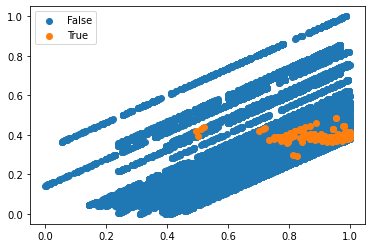

Counter({False: 14210, True: 7105})


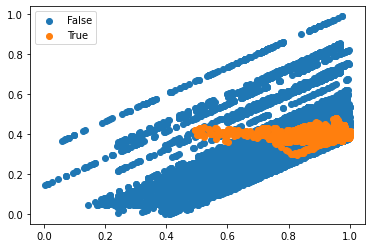

In [131]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#Visualise class distribution before rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('o', over),('u', under)]
pipeline = Pipeline(steps=steps)

# transform the dataset
modelsData_trainFeatures, modelsData_trainLabels = pipeline.fit_resample(modelsData_trainFeatures, modelsData_trainLabels)

#Visualise class distribution after rebalancing
summariseClassDistribution(modelsData_trainFeatures, 
                           modelsData_trainLabels)

## 4.3 Modeling - Random Forest (OLD, only used for quick testing)

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.994957        0.5  0.622222  0.554455  0.59322  0.520446   

   Average Precision  
0           0.313016  

--------------------------------------------------------------------


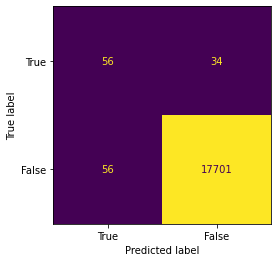

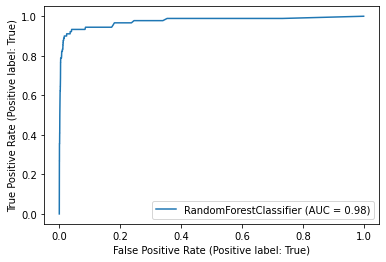

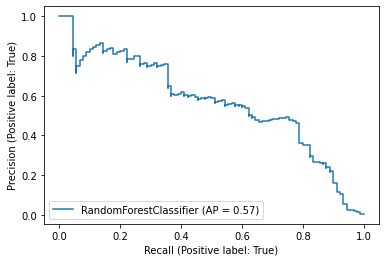

In [132]:
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

# Instantiate model with 100 decision trees
rf = RandomForestClassifier(n_estimators = 1000, n_jobs=-1)

# Train the model on training data
rf.fit(modelsData_trainFeatures, modelsData_trainLabels.astype(bool));

#Display the model performance    
showModelPerformance(trainedModel = rf, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)


In [ ]:
import time
import numpy as np

start_time = time.time()
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

import pandas as pd
import matplotlib.pyplot as plt
forest_importances = pd.Series(importances, index=[processedData_dealServiceFeatureNames])

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.4 Modeling - XGBoost (OLD, only used for quick testing)

In [ ]:
import xgboost as xgb

# Instantiate xgboost
GXBoost = xgb.XGBClassifier(#scale_pos_weight=1,
                            learning_rate=0.17,
                            colsample_bytree = 0.4,
                            subsample = 1.0,
                            objective='binary:logistic',
                            n_estimators=750,
                            max_depth=12,
                            gamma=0.03,
                            n_jobs=-1
                           # seed=27
)



# Train the model on training data
GXBoost.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = GXBoost, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

# OLD Model Pipeline - Light GBM

Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.995069   0.508475  0.666667  0.576923  0.627615  0.533808   

   Average Precision  
0           0.340664  

--------------------------------------------------------------------


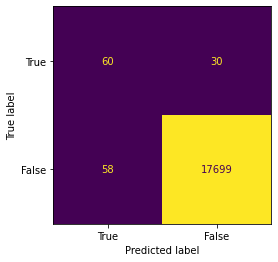

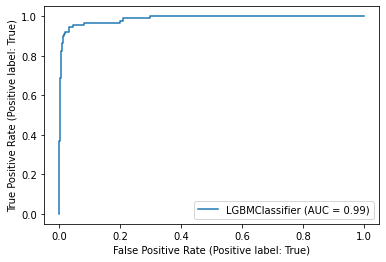

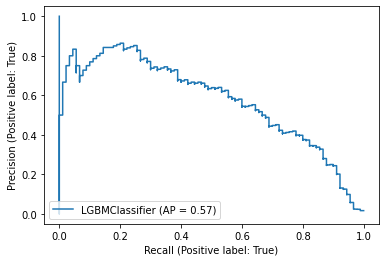

In [133]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import the model we are using
import lightgbm as lgb

# Instantiate Light GBM
LightGBM_Model = lgb.LGBMClassifier(n_jobs=-1, n_estimators = 3400, max_depth = 25)                         

# Train the model on training data
LightGBM_Model.fit(modelsData_trainFeatures, modelsData_trainLabels);

#Display the model performance    
showModelPerformance(trainedModel = LightGBM_Model, 
                     testFeatures = modelsData_testFeatures, 
                     testLabels = modelsData_testLabels)

In [ ]:
for i in range(10):

# Model - Pipeline for GXBoost

In [134]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=15,shuffle=True)

# define search space
space = dict()
space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

KeyboardInterrupt: 

In [ ]:
cv_score = optimizedGXBoostModel.best_score_
test_score = optimizedGXBoostModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer
fhalf_scorer = make_scorer(fbeta_score, beta=0.5)

for i in range(25):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    GXBoostPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    #['under', RandomUnderSampler()],
                                ['classifier', xgb.XGBClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__learning_rate'] = [0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50, 0.55, 0.60]
    space['classifier__max_depth'] = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
    space['classifier__min_child_weight'] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    space['classifier__gamma'] = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    space['classifier__colsample_bytree'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    spaceEmpty = dict()

    GXBoostSearch = RandomizedSearchCV(estimator = GXBoostPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring=fhalf_scorer, 
                            n_jobs=-1, 
                            cv = stratified_kfold)

    optimizedGXBoostModel = GXBoostSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    
    cv_score = optimizedGXBoostModel.best_score_
    test_score = optimizedGXBoostModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedGXBoostModel.best_params_)
    
    #feature importance
    importances = optimizedGXBoostModel.best_estimator_._final_estimator.feature_importances_
    for i,v in enumerate(importances):
        print(v)



    #Display the model performance    
    showModelPerformance(trainedModel = optimizedGXBoostModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:14:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 11403.837 seconds
Cross-validation score: 0.7757145444535565
Test score: 0.7812499999999999
Best Hyperparameters: {'classifier__min_child_weight': 10, 'classifier__max_depth': 20, 'classifier__learning_rate': 0.3, 'classifier__gamma': 0.6, 'classifier__colsample_bytree': 0.4}
0.011394889
0.032656018
0.0261843
0.011768988
0.01651382
0.009361308
0.006273642
0.0036932079
0.005455474
0.011123369
0.0029002905
0.0
0.014173302
0.012430672
0.008337721
0.0066977395
0.0026501494
0.001635374
0.0039611883
0.0043424126
0.027145745
0.02105507
0.0072234552
0.006488641
0.0030079654
0.0005656126
0.005507935
0.011643245
0.019282022
0.004660468
0.0072060893
0.0
0.004

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[07:11:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 10645.227 seconds
Cross-validation score: 0.8024635238998099
Test score: 0.6866197183098592
Best Hyperparameters: {'classifier__min_child_weight': 8, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.15, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.6}
0.008330777
0.03162562
0.020698024
0.013030562
0.015371437
0.0064038807
0.0064802202
0.007551145
0.008831705
0.004262059
0.0
0.0035604883
0.009695109
0.012489432
0.006752067
0.0148933735
0.00067091855
0.0
0.006491136
0.002618051
0.018837098
0.02491297
0.0044596256
0.009030034
0.0035794731
0.0020917575
0.0061061797
0.00497325
0.0012371732
0.014517672
0.0132202115
0.0054617887
0.

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:12:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Elapsed time to compute best fit: 10837.444 seconds
Cross-validation score: 0.7871390751605445
Test score: 0.7770270270270271
Best Hyperparameters: {'classifier__min_child_weight': 5, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.0, 'classifier__colsample_bytree': 0.8}
0.008012398
0.02808484
0.023111546
0.0145934345
0.012760392
0.0040567946
0.004159175
0.0067713195
0.007297424
0.007867958
0.0026758478
0.008564101
0.0084668165
0.011850099
0.0074734846
0.012205152
0.0030444905
0.0
0.003890468
0.0019619633
0.020562125
0.024998084
0.0036575014
0.010710203
0.0034382367
0.0038980069
0.0072637247
0.008326687
0.012440373
0.0066599944
0.0076812296
0.00

# Model - Pipeline for Random Forests

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the model we are using
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


pipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy=0.1, n_jobs=2)],
                             ['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict() 
space['classifier__n_estimators'] = [1000, 1100, 1200, 1300, 1400]
space['classifier__max_depth'] = [9, 10, 11, 12, 14, 15, 16]
space['classifier__min_samples_split'] = [1, 2, 3]


search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedRFModel = search.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedRFModel.best_score_
test_score = optimizedRFModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.295 seconds
Cross-validation score: 0.12875831016797748
Test score: 0.1266614542611415
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.937412   0.067782  0.964286  0.126661  0.264533  0.083265   

   Average Precision  
0            0.06553  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.052 seconds
Cross-validation score: 0.12475637359992249
Test score: 0.1437670609645132
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.947274   0.077833  0.940476  0.143767  0.292376  0.095319   

   Average Precision  
0            0.07348  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.174 seconds
Cross-validation score: 0.12895594149037545
Test score: 0.16069699903194576
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.95142    0.08746  0.988095  0.160697  0.322957  0.106959   

   Average Precision  
0           0.086475  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.928 seconds
Cross-validation score: 0.1274588139294803
Test score: 0.1396551724137931
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0   0.94408   0.075279  0.964286  0.139655  0.286827  0.092297   

   Average Precision  
0           0.072758  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.793 seconds
Cross-validation score: 0.1352662337826856
Test score: 0.14535901926444836
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.945313    0.07845  0.988095  0.145359  0.297704  0.096154   

   Average Precision  
0           0.077572  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.022 seconds
Cross-validation score: 0.13793292195351764
Test score: 0.1320450885668277
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1        F2      F0.5  \
0  0.939598   0.070812  0.97619  0.132045  0.274431  0.086938   

   Average Precision  
0           0.069238  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 2.777 seconds
Cross-validation score: 0.13219141024056227
Test score: 0.12887828162291168
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1       F2      F0.5  \
0  0.938645   0.069054  0.964286  0.128878  0.26839  0.084799   

   Average Precision  
0           0.066756  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.107 seconds
Cross-validation score: 0.1334770521366448
Test score: 0.162839248434238
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.955062   0.089245  0.928571  0.162839  0.322314  0.108939   

   Average Precision  
0           0.083206  

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.123 seconds
Cross-validation score: 0.12816293923200886
Test score: 0.1275272161741835
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision   Recall        F1       F2     F0.5  Average Precision
0  0.937132    0.06822  0.97619  0.127527  0.26658  0.08381           0.066707

--------------------------------------------------------------------


C:\Python39\lib\site-packages\sklearn\model_selection\_search.py:285: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time to compute best fit: 3.068 seconds
Cross-validation score: 0.13650471583242504
Test score: 0.15717092337917485
Best Hyperparameters: {}
Legend
Recall -  measures the fraction of relevant links that are retrieved
Precision - measures the fraction of retrieved links that are relevant
F-measure - measures the harmonic mean of recall and precision
F2-measure - favors recall
F0.5-measure - favors precision
Average Precision - summarizes a precision-recall curve as the weighted mean of precisions achieved at each threshold

   Accuracy  Precision    Recall        F1        F2      F0.5  \
0  0.951925   0.085653  0.952381  0.157171  0.314961  0.104712   

   Average Precision  
0           0.081799  

--------------------------------------------------------------------


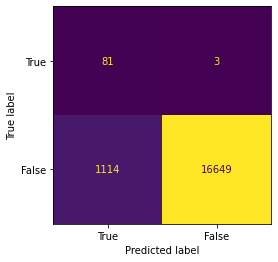

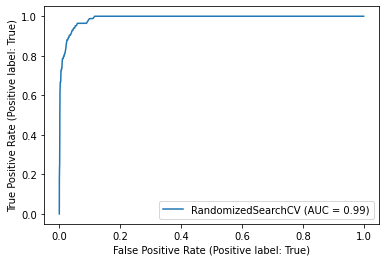

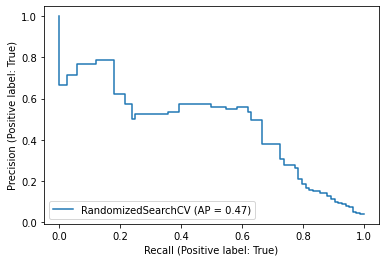

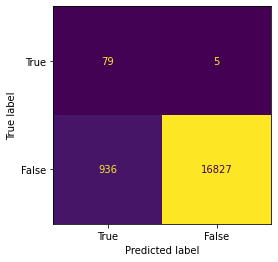

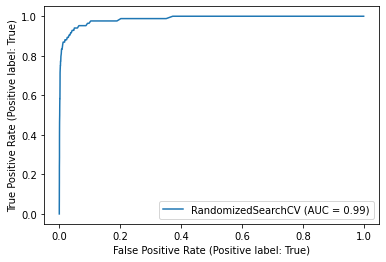

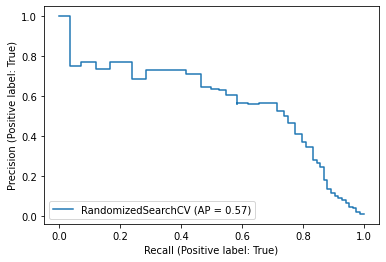

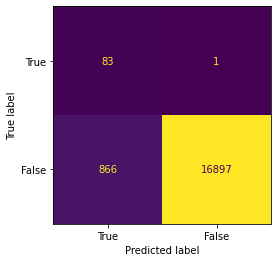

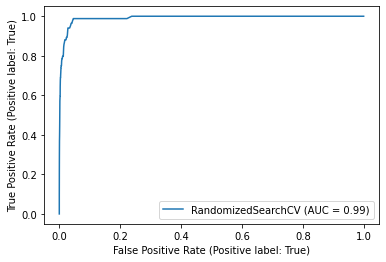

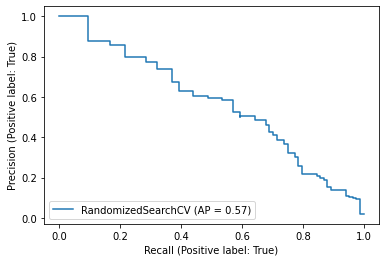

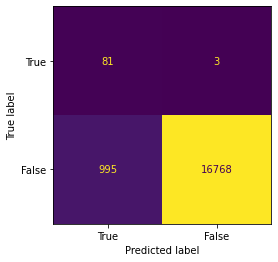

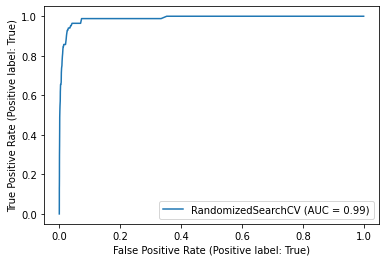

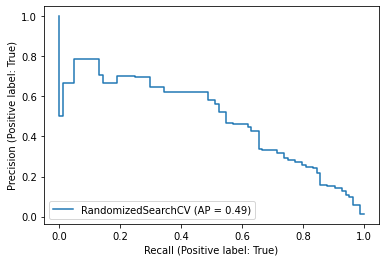

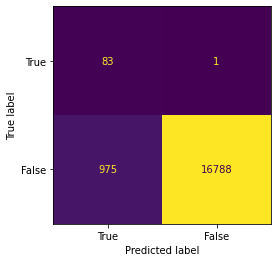

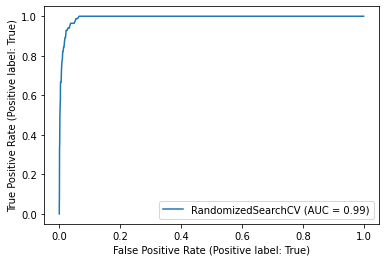

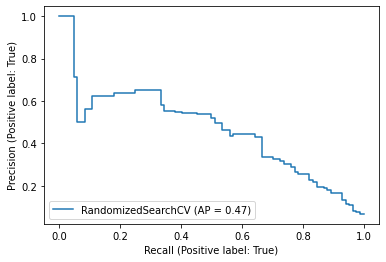

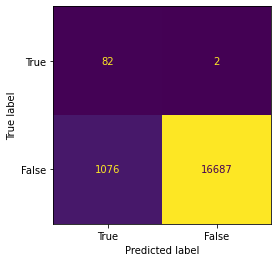

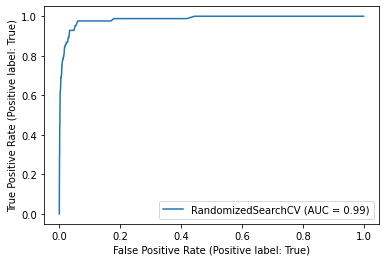

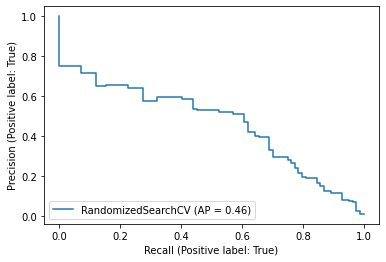

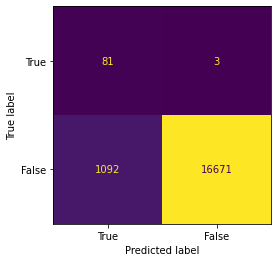

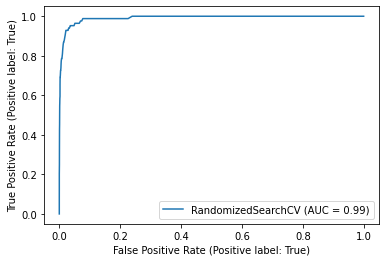

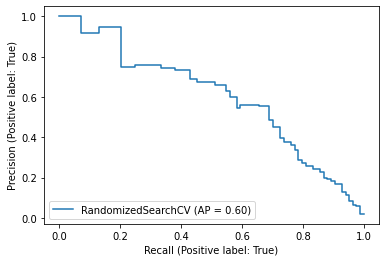

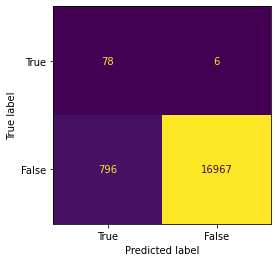

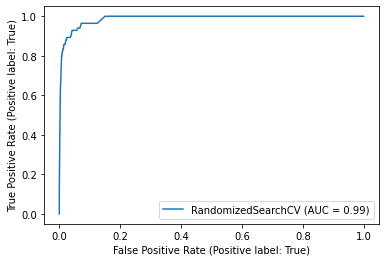

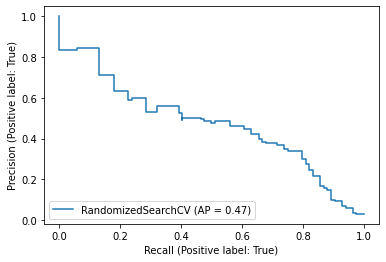

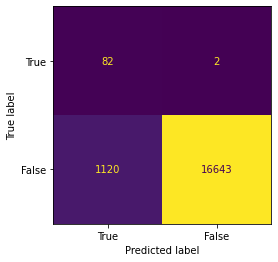

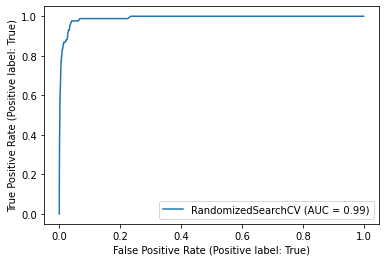

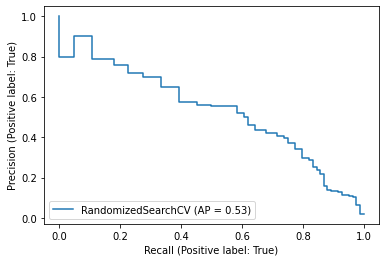

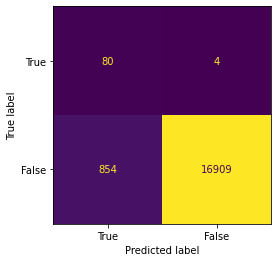

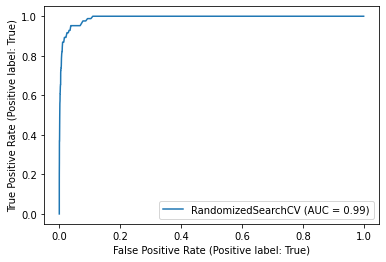

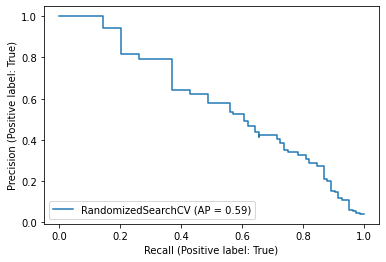

In [172]:
for i in range(10):

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    pipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                              ['under', RandomUnderSampler()],
                                ['classifier', RandomForestClassifier(n_jobs=2)]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    spaceEmpty = dict() 

    search = RandomizedSearchCV(estimator = pipeline, 
                            param_distributions=spaceEmpty, 
                            n_iter=100, 
                            scoring='f1', 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedRFModel = search.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedRFModel.best_score_
    test_score = optimizedRFModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedRFModel.best_params_)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedRFModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

# Model - Pipeline for Light GBM

In [ ]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

ftwo_scorer = make_scorer(fbeta_score, beta=2)

start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


LightGBMPipeline = Pipeline(steps = [#['smote', SMOTE(sampling_strategy = 0.1, n_jobs=2)],
                                    #['under', RandomUnderSampler(sampling_strategy = 0.5)],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2)]])

stratified_kfold = StratifiedKFold(n_splits=5,shuffle=True)

# define search space
space = dict()
space['classifier__num_leaves'] = [60, 70, 80, 90, 100]
space['classifier__max_depth'] = [5, 6, 7, 8]
space['classifier__min_data_in_leaf'] = [250, 500, 750, 1000, 1250, 1500]


LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

elapsed_time = time.time() - start_time

print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")

In [ ]:
cv_score = optimizedLightGBMModel.best_score_
test_score = optimizedLightGBMModel.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)


#Display the model performance    
showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68653773 0.65899507 0.6908681  0.67460269 0.66751483 0.69938493
 0.69262749 0.68760868 0.6952315  0.69575581 0.70932569 0.65241234
        nan 0.68348972 0.67344375 0.67879953 0.66896753        nan
 0.69014311        nan 0.67389725 0.66712434        nan 0.66465861
 0.68723218 0.69720619 0.6897703  0.67131535 0.68722085 0.69735269
 0.68426501 0.67890952 0.6499091  0.67656082 0.67814078 0.67288988
 0.66994538 0.65670764        nan 0.70221754 0.71167406 0.67657727
        nan 0.70142712        nan 0.67579897 0.69870269 0.66329696
 0.40117965 0.64970145 0.69176397 0.689065          nan        nan
 0.66069382 0.69019108 0.70404299 0.68348713        nan 0.68478259
        nan 0.6476234  0.69914471 0.66695789 0.679816   0.68314616
 0.67389643 0.69447452 0.65000346 0.69277635        nan 0.66574425
 0.66670305 0.68195748

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 3165.885 seconds
Cross-validation score: 0.7116740582552505
Test score: 0.7575757575757577
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 800, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.6}
309.9246138403796
33202.61625626221
52099.06398674457
2609.1115195475177
5461.361875657665
161.19833602964718
71.72713483731786
150.316820736276
61.562187763622205
34.86355340584123
114.85989242102369
12.973656656453386
1143.2560662161995
1898.0211339243106
312.02434340334366
0.0
775.0297946086575
0.0
35.42796292348066
3.021763628901681
1783.6530897960329
444.0387184445899
1536.780281305255
275.548998603932
4.980224690458272
4.180869419113151
39.60774436947395
14.433093063296837
4.661109924316406
149.8715426833951
9.34491821314441
0.04985795577522367
28.998670148

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.74589083 0.70930257 0.72224219 0.70206161 0.70958909 0.69885834
 0.72489903 0.71681752 0.6953149  0.7035839  0.70523596 0.71160588
 0.69411882 0.63281195 0.71666796 0.71947113 0.70165146 0.707396
 0.69071785 0.66116366 0.70952452 0.72385253 0.71044158 0.72395948
 0.73202163 0.6964371  0.72434122 0.71325871 0.69033892 0.70572289
 0.72842959        nan 0.72766787 0.72044202 0.73642585 0.68514038
 0.73447273 0.67406319 0.66109755 0.6993864  0.70167655 0.71842223
 0.70670428        nan 0.72023241 0.7049783  0.69494163        nan
 0.71378274 0.69604994 0.69712857 0.72683697 0.71949118        nan
        nan 0.70193747 0.71174599 0.71121835 0.69879048 0.72235566
 0.72218733 0.6994453  0.71039286 0.70650949 0.69530547 0.70872426
 0.70817597 0.72213971 0.72577686 0.71067368 0.71598694        nan
 0.70783143        nan 0

[LightGBM] [Warning] min_data_in_leaf is set=800, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=800
Elapsed time to compute best fit: 3277.066 seconds
Cross-validation score: 0.7458908331385825
Test score: 0.7007125890736341
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 800, 'classifier__max_depth': 300, 'classifier__max_bin': 350, 'classifier__learning_rate': 0.3}
727.572791354407
57010.771021374654
84733.06712265652
5485.242255607023
9255.937284315283
161.6323264102825
76.375100422561
67.45037838745114
94.8645166681381
61.63739971429739
261.65702042379417
8.851390005375833
3075.041203814947
1966.3375166841276
807.5435435609452
0.0
292.3115010003018
0.0
56.50734953347104
21.595664914301885
4808.820719162965
390.77355147371975
2283.5671912198195
51.65525784728197
14.929354054513169
3.7501115794075304
115.60110057673046
32.49297920928075
10.972259489332204
39.16464275016551
37.63143584004138
3.933034517664055
116.60077192718

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68923317 0.67589036 0.70722553 0.69531289 0.68871085 0.68412763
        nan 0.69820351 0.69208998 0.68861598 0.67766188 0.6857578
 0.68411097 0.67919772        nan 0.67409968 0.68439141 0.68166872
 0.70084159 0.70853913        nan        nan 0.68908825 0.6801601
 0.69741194 0.68018219 0.68057023 0.67087128 0.70017889 0.71016556
 0.70546731 0.69145362 0.69026881 0.6923267  0.69469322 0.72086706
 0.67993012 0.66473985 0.67527006 0.70085142 0.68223046 0.69444272
        nan 0.6911919  0.68753885        nan 0.68656485 0.70823305
 0.67512011        nan 0.6896401  0.69170146 0.70741159 0.64848923
 0.68004568 0.6770937  0.70209518 0.69637418 0.69302414 0.68406771
 0.69230799 0.6870855  0.67916006 0.68534404 0.68842944        nan
 0.69759764        nan 0.69161898 0.71625303 0.70468789 0.68188662
 0.70346936 0.67750625 0

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3276.052 seconds
Cross-validation score: 0.7208670594340524
Test score: 0.6705882352941176
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 400, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.3}
665.9065164402127
41010.94230927527
90663.49659469724
10731.770844772458
5343.260680288076
10.987495020031929
90.14121054112911
127.8769945949316
750.3423812687397
16.17772190272808
166.5608245432377
31.67442561686039
2567.7261744514108
8840.037819422781
465.11988155543804
0.0
358.7989354580641
0.0
47.162134632468224
14.370487779378891
4992.944811537862
1028.4645729064941
5381.217353343964
29.85866031050682
16.01413157582283
3.2881829738616943
15.802149951457977
30.473780870437622
1.314769983291626
26.479732513427734
0.0
8.644829422235489
16.904848039150238
129.8

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.70233198 0.70201313 0.71389297 0.69311361 0.7002277
 0.69103947        nan 0.70531108 0.69103238 0.69273489 0.72713234
 0.70281676 0.71451004 0.69239797 0.7168841  0.72910562 0.70036211
 0.67790335 0.67719386 0.70311706        nan 0.70896053 0.7005372
 0.69113637 0.70657005 0.70969183 0.62803922 0.70593347 0.72953227
 0.70276728 0.70534887 0.7004296  0.7275529  0.68356859 0.70356245
 0.6807203  0.72557513 0.71537515 0.69079649 0.7086824  0.71998891
        nan 0.71383314 0.70943428 0.70207299 0.70848607 0.69055946
 0.69628034 0.71486693 0.7127819  0.72501575 0.67701784 0.6973136
 0.70534824 0.70165099 0.69789942 0.72589979        nan 0.69577358
 0.70201711 0.70241215 0.68905233 0.71610947 0.70519042 0.71795361
 0.6368764  0.61341517 0.72500435 0.71208681 0.72140619 0.66887692
 0.71270083 0.72231086 0.

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3140.559 seconds
Cross-validation score: 0.7295322654308333
Test score: 0.6557377049180327
Best Hyperparameters: {'classifier__num_leaves': 21, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 800, 'classifier__max_bin': 200, 'classifier__learning_rate': 0.3}
1217.510181857273
52095.339577963576
88799.37793330848
5585.533580662683
8084.87221628055
83.38613958097994
93.85720247402787
267.1568400748074
18.628142073750496
70.80426122248173
92.22409793362021
3.5865279845893383
3182.1655433811247
3357.5002891793847
514.4473666399717
0.0
584.9537900146097
0.0
41.50883002951741
8.22705090790987
3591.941411761567
1215.779126726091
2707.6877925917506
7.852940361946821
110.38909487426281
6.6626200675964355
4.002234995365143
116.55670642107725
1.3479100465774536
538.5229731760919
0.17203199863433838
30.538248039782047
7.85979280

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.66656345 0.68020072 0.67645429        nan 0.63410754 0.67318133
 0.68703127 0.67790192        nan        nan 0.69322485        nan
 0.68423357        nan 0.66851449 0.65936753 0.68262574 0.67786751
 0.68515405 0.65935834 0.68607052 0.67055761        nan 0.68060109
 0.71631739 0.6929118  0.68161869 0.68688568 0.69090478 0.66806551
 0.68715088 0.68435784 0.69079237 0.69845319 0.6721331  0.69099531
        nan        nan 0.67361229 0.66895162        nan 0.68586522
 0.67227941 0.7013562         nan 0.64032289 0.70812798 0.68173397
        nan 0.70505039 0.68175321 0.66653771 0.69594935 0.70279366
 0.7015267  0.69720379 0.70916782 0.67192094 0.67156611 0.68402262
 0.65528521 0.50094138 0.68774848 0.66573809 0.67169592 0.68643021
 0.70621634 0.69957977 0.67450949 0.6801644  0.69075262 0.69329522
 0.6872536  0.67002788

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 3230.947 seconds
Cross-validation score: 0.716317391132861
Test score: 0.7241379310344828
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 200, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.3}
602.493834412453
47356.38192742335
93061.79926580095
6924.676332327392
7938.2710373104865
299.2131743004029
82.09350373019697
20.01261280674953
79.54122227441985
37.29671202449936
279.3228391855664
8.333071204571752
4372.756610686658
410.7318900935607
175.17503364223012
0.0
618.0322295358928
0.0
69.77025114942444
91.65139478826313
3765.5276303590517
1355.5423895760323
1164.5582315268402
1222.6722109762777
13.387631280027563
5.487853424623609
176.5861396124128
17.994843430437868
31.007596650131745
79.09655893198214
71.18197846459225
16.283251781045692
31.5489226899

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.683685   0.69407426        nan 0.67944468 0.66494254
 0.70349017 0.6955303  0.68991201 0.66081595 0.70328509 0.68886111
 0.69556546        nan 0.69462744        nan 0.6904297         nan
 0.69072302 0.7078381  0.68833776 0.71092878 0.66594054 0.68536592
 0.69746887 0.68952843 0.70075016 0.670093   0.68650744 0.68073104
 0.67909169 0.7020885         nan 0.68339233 0.69202056 0.68270879
 0.69671048 0.68952973 0.68496973 0.67844277 0.71093883 0.68088523
 0.67508983 0.69974008 0.6968422  0.70357847 0.69326929 0.56613207
 0.70723994 0.69798111 0.66177754 0.70576607        nan 0.68533772
 0.66451097 0.69453182        nan 0.68638419 0.69485207 0.70213879
 0.70361157 0.67804209 0.69253548 0.67588634        nan 0.68873488
 0.690628   0.70134146 0.68616382 0.70918853 0.70613136 0.67483906
 0.69929523 0.70669796

[LightGBM] [Warning] min_data_in_leaf is set=900, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=900
Elapsed time to compute best fit: 3254.237 seconds
Cross-validation score: 0.7109388250070765
Test score: 0.6812933025404156
Best Hyperparameters: {'classifier__num_leaves': 26, 'classifier__min_data_in_leaf': 900, 'classifier__max_depth': 700, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.2}
786.1599092930555
67580.39846970141
124717.0002297759
11515.352704256773
10680.38467912376
267.8015902340412
240.5952831208706
220.5146238207817
70.73831163346767
25.373351216316223
73.16924953460693
10.380813002586365
5505.963553249836
10288.205860361457
89.48714917898178
0.0
425.6817430257797
0.0
178.62506319582462
43.535824194550514
5123.802999541163
424.5131711214781
3923.3057481348515
33.19851240515709
7.381400883197784
8.125900998711586
293.08828254044056
37.1190202832222
9.206093221902847
182.15820789337158
0.5340840220451355
5.612815901637077
49.013782441

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.68086017 0.7139141  0.70740738 0.68334176 0.70643382 0.71165762
 0.69019304 0.71156899 0.67682605        nan 0.70124374 0.70983627
 0.70500901 0.70475386 0.72358724 0.66457268 0.70286254 0.72428855
 0.67803493 0.6630176  0.69331295 0.70423172 0.71014052 0.70778827
 0.70129464        nan 0.70811211 0.70825086 0.69910456 0.69060544
 0.72183407 0.70107421 0.70640683 0.66865051 0.71359915 0.71551027
 0.69853867 0.68465192 0.68995215 0.68986992 0.71274636 0.69300602
 0.70019905 0.6970686         nan        nan 0.6796527         nan
 0.68331285 0.67591776        nan 0.69227133 0.69099287        nan
 0.68628165 0.70047685 0.70041748 0.69540035 0.71215714        nan
 0.71820384 0.69990193 0.70243366 0.70256416 0.72589513 0.72870741
 0.71416327 0.69375038 0.69376012 0.69343161        nan 0.69836018
 0.70930218 0.71364046

[LightGBM] [Warning] min_data_in_leaf is set=400, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=400
Elapsed time to compute best fit: 3218.112 seconds
Cross-validation score: 0.7287074110611995
Test score: 0.6610576923076923
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 400, 'classifier__max_depth': 100, 'classifier__max_bin': 100, 'classifier__learning_rate': 0.2}
518.3142071217299
80995.55867231451
126970.97174832039
6446.880016069859
11389.674958117306
84.10658121854067
30.680994108319283
71.31085593253374
186.87332552671432
63.48430699855089
792.0464483294636
46.84156699478626
4345.85567076318
457.1425150837749
271.66137230582535
0.0
946.6194997094572
0.0
103.35061109252274
8.9210423566401
6517.092374380678
1059.4320517145097
3020.2656280938536
663.3686666563153
108.30191594362259
43.92671129107475
124.98179829120636
240.47285656630993
13.892843347042799
123.50691463053226
25.20550501346588
11.816720128059387
103.540120

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_plot\precision_recall_curve.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69508113        nan 0.70593556 0.68004819        nan
 0.69455995 0.70108888 0.70119033 0.66977269 0.69635355 0.70362701
 0.69433714 0.70335004 0.71140021 0.70244161 0.70443886 0.71578972
 0.70924229 0.67818478 0.68312775 0.68736867 0.70471121 0.70677186
 0.64154279 0.61051631 0.7047248  0.69642348 0.69613131 0.71056922
 0.66827961 0.69876633 0.68801649        nan 0.69941351 0.69570202
 

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 3077.075 seconds
Cross-validation score: 0.7228090563156782
Test score: 0.7223476297968398
Best Hyperparameters: {'classifier__num_leaves': 56, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 200, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.1}
7259.901887268061
126184.74100142159
241389.94832233293
17494.888445171528
30123.996135874477
556.73013709113
75.97902709618211
185.70030645281076
69.13241200894117
66.27510442584753
77.98087167739868
1.8796425051987171
6182.2694236934185
6103.2593264412135
835.2138130050153
0.0
1997.888584012282
0.0
117.52171681262553
66.92441403516568
10749.864921518601
2050.3134214105085
10868.486439935157
301.0039143394679
82.46484224498272
1.3587229698896408
72.16618327796459
215.42638500779867
45.60939468210563
349.8139410279691
73.57728327717632
14.49982088804245
207.70966

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.67878067 0.69897298 0.70497322 0.68589445 0.68486387 0.7175124
 0.70102179 0.70776456 0.71963822 0.71819661 0.69720705 0.68558101
        nan 0.66243015 0.66346933 0.44458466 0.6870913  0.71297697
 0.70158737 0.70908401 0.67390941 0.48607131 0.69926555 0.6915819
 0.71258433 0.70090853        nan 0.68544933 0.68724228 0.70265303
 0.68779785 0.68037788 0.67662265 0.66409366 0.67569503 0.68449679
 0.66358812 0.66463021 0.66868042 0.67203192 0.6897515  0.68599463
 0.66904426 0.69283333 0.69385215 0.68863944        nan 0.6942674
 0.67208726 0.68819021 0.69176042 0.72257539 0.69258635 0.70062527
 0.70341364 0.68320812 0.61971877 0.69586059        nan 0.68836926
        nan 0.69442094 0.71006219 0.67889937 0.69737846 0.67861915
 0.68793201 0.69908066        nan 0.68099164 0.69451638 0.69712562
 0.70695842        nan 0.

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3345.252 seconds
Cross-validation score: 0.7225753854343668
Test score: 0.7424593967517401
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 500, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.3}
1105.4376033019507
40947.105212899274
93746.16180634474
6558.883352421428
10981.958254181489
165.26112957573787
101.67546240135562
99.33988889306784
76.32650929843658
25.82371796958614
300.14900158310775
0.6850389753235504
2894.9289091368555
3979.256836970977
659.8168826076435
0.0
428.87626387318596
0.0
137.30610027023067
32.40640230115969
3354.0904719100217
429.6694654332241
4582.251130911754
62.99034542404115
27.13046875060536
0.1644315030425787
67.39678532860125
762.9755407025223
7.962752661667764
136.93135845614597
20.235059724072926
18.45072205719771
527.387

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69181861 0.70041412 0.68489019 0.70411984 0.68560701 0.69449265
        nan 0.68503962 0.69876447 0.68920155 0.6981567  0.68929839
 0.65533546 0.70603965        nan 0.69579155 0.695325   0.69484276
 0.67873629 0.6686238  0.70016605 0.70254715 0.70061653 0.70094736
        nan 0.68840211 0.72317618 0.65269905 0.70072032 0.69339601
 0.6978226  0.70809024 0.70118092 0.66277219 0.68985345 0.71096377
 0.67641942 0.6697948         nan 0.71298118 0.68177613 0.69003606
 0.70620042 0.70279888 0.71054511        nan 0.69225264 0.6915515
 0.69740527 0.70105023 0.67959599 0.69609496 0.68277472 0.73241913
 0.70758607 0.68758819 0.68770492 0.69753402 0.66574813 0.69618265
 0.67693969 0.69826297 0.72662531 0.71104714        nan        nan
 0.68437321 0.69480399 0.70066524 0.68509969 0.48646661 0.70501039
 0.69846136 0.69556206 

[LightGBM] [Warning] min_data_in_leaf is set=300, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=300
Elapsed time to compute best fit: 3177.714 seconds
Cross-validation score: 0.7324191320484299
Test score: 0.6635071090047394
Best Hyperparameters: {'classifier__num_leaves': 31, 'classifier__min_data_in_leaf': 300, 'classifier__max_depth': 400, 'classifier__max_bin': 300, 'classifier__learning_rate': 0.4}
768.9609841362762
40332.43455344198
69769.62587197614
4683.472976551318
7236.560481143664
57.701826837903354
180.2898287224234
80.53495036647655
306.7542661902553
58.72358461935073
67.16799024760257
8.830112776136957
1256.7960681737604
3394.2971137543936
496.2546626481053
0.0
1016.6403517555736
0.0
17.170615403818374
10.244825036003022
3315.247002781369
544.5294318933447
2650.9688920677
550.1215819078934
22.478783472208306
0.024304330465383828
35.64062501715671
254.88501486901077
17.836821360018803
10.537814752897248
8.268685907125473
4.147641872055829
20.8824286

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.69300864 0.67779545        nan 0.68561422 0.66416572
 0.70407989        nan 0.68292539 0.68665747 0.68513878 0.69014168
 0.66135892 0.69309055 0.71072232 0.70390778 0.67734989 0.68772726
 0.67724321 0.68371364 0.66679033 0.48001011 0.69348502        nan
 0.70657104 0.67211299 0.69736994 0.67837121 0.69086598 0.65597157
 0.6987956  0.69954765 0.69185367 0.68901085 0.41057792 0.67722903
 0.68663023 0.69294143 0.70620691 0.70397676        nan 0.68171656
 0.70105375 0.68493611 0.68698431 0.70418389        nan 0.68983514
        nan 0.67257852 0.69499543 0.65695134 0.62213553 0.67931303
 0.69833753        nan        nan 0.69979864 0.70753453 0.6537972
 0.69915233        nan 0.69372923 0.66182106 0.65592904 0.58681504
 0.70867859 0.69756564 0.6878761  0.68060813 0.70266266 0.67760606
 0.69981404        nan 

[LightGBM] [Warning] min_data_in_leaf is set=600, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=600
Elapsed time to compute best fit: 3307.260 seconds
Cross-validation score: 0.7173630913619697
Test score: 0.6931818181818181
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 600, 'classifier__max_depth': 400, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.2}
378.53239453956485
68517.78668407723
134183.30967370607
11223.810169117525
8940.822373664007
429.2639577910304
110.20599673688412
412.29104356467724
160.20182021707296
447.350513279438
523.5804496109486
58.13975737243891
5702.674054611474
789.2990175262094
209.24883246421814
0.0
1024.2608684413135
0.0
63.795646235346794
24.11501944810152
4444.576292492449
744.3126810379326
3268.5850776545703
1698.36939881742
23.543705036863685
13.067835487425327
36.01067283004522
692.7544231750071
172.4075492322445
291.0987195149064
38.04321867227554
13.585443675518036
82.5431395

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.70603248 0.70698578 0.71291374 0.72663457 0.70991107 0.71080175
 0.69331172 0.70764233 0.67529819 0.70756447 0.71761255 0.69798722
 0.7179155  0.71125631 0.71027191 0.70767706 0.69900963 0.68508416
 0.69567661 0.72088361 0.68838896 0.70847977 0.70124475        nan
 0.7317493  0.7243377  0.7276298  0.71450714 0.69643811 0.70426213
 0.63957519 0.70998467 0.6940642  0.70875929 0.70305181 0.69840933
 0.68863966 0.69477853 0.68815879 0.7141917  0.70440382 0.70611312
 0.70121832 0.67485912 0.69801578 0.69561434 0.69671013 0.72067087
 0.72562324 0.73203225 0.70187013 0.71968101 0.71485373 0.70957088
 0.7020233         nan 0.70429966 0.69575807 0.69801392 0.68362506
 0.70348174 0.72020669 0.69558654 0.7001482  0.68978645        nan
 0.69783591 0.72340956 0.73439931 0.68930484 0.69875762 0.70941891
 0.70291047 0.70315626

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3526.671 seconds
Cross-validation score: 0.7343993062441104
Test score: 0.735632183908046
Best Hyperparameters: {'classifier__num_leaves': 41, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 100, 'classifier__max_bin': 450, 'classifier__learning_rate': 0.2}
5591.51482909359
66310.58404203644
128645.36646897811
6805.373852636199
12015.283180616796
248.73015810502693
590.115835107863
57.70652796700597
42.93637389317155
71.57774791866541
128.31321450695395
50.91979717463255
1544.4392203097232
13596.662191827316
234.46044536679983
0.0
459.4431878719479
0.0
38.433169919997454
23.74453894700855
4887.590913536493
423.93264781683683
2591.167944015935
1368.1470570899546
29.157020526006818
0.9438915923237801
39.52499132882804
1154.470850624144
17.037758139893413
22.98010028898716
82.17783973924816
2.5598844662308693
189.771698

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.6938033  0.68173517 0.7203371  0.69168075 0.68706202 0.70813298
 0.46057948 0.68819092 0.67169175 0.68192939 0.67963991 0.72128883
 0.71495964 0.69509093 0.71434695 0.70607841 0.69023412 0.71726671
 0.70541249 0.69786862 0.72821526 0.7146249  0.6927748  0.65449322
 0.68009013 0.69957373 0.71105856 0.69578144        nan 0.72809232
        nan 0.70294129 0.68546467 0.72348347 0.68841498 0.69475206
 0.69330848        nan 0.7074637  0.67622013 0.70357807 0.7003032
 0.65938244 0.69081971 0.68573876 0.70512812 0.71845474        nan
        nan 0.69247456 0.69050057 0.69904308 0.72415458 0.67935235
 0.71804802        nan 0.71831012 0.70494547 0.72034676 0.6767025
 0.7133077  0.70823596 0.70002044 0.67586512 0.70497933        nan
 0.69335759 0.69820573 0.66942448 0.68856974 0.67734188 0.69627701
        nan 0.67802406 0

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
Elapsed time to compute best fit: 3141.358 seconds
Cross-validation score: 0.7319404386790006
Test score: 0.7799145299145299
Best Hyperparameters: {'classifier__num_leaves': 36, 'classifier__min_data_in_leaf': 100, 'classifier__max_depth': 600, 'classifier__max_bin': 255, 'classifier__learning_rate': 0.1}
3544.0179981589317
153339.84176176786
240951.16405284405
11339.26901614666
25601.724336504936
254.3207130432129
501.4170696735382
134.451136469841
608.5226440429688
56.559242367744446
1524.9645406007767
45.476951241493225
4959.787585258484
5575.680374741554
1416.8525156378746
0.0
1189.3587774038315
0.0
282.95768612623215
43.35084384679794
7904.795566856861
1558.928860783577
5784.499622702599
34.717384576797485
121.64863133430481
27.853150129318237
147.34299635887146
77.64156919717789
12.937299728393555
95.61859941482544
86.5251100063324
158.63189935684204
35.5209

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.69205002 0.6881292  0.68772577 0.68055293        nan 0.70843678
 0.68976344 0.69918916 0.68943847 0.70341092 0.68272237 0.67768859
 0.66698185 0.68266656 0.66821775 0.67439656 0.67527601 0.68419466
 0.70057803 0.70861462 0.67570056 0.70066238 0.66886323 0.68406742
 0.70831513 0.67545983 0.67328591 0.67602345 0.68552952 0.69337437
 0.64330751 0.69183287 0.68965445 0.71177364 0.67390576 0.68785888
 0.69606376        nan 0.66886671 0.70233886 0.7035188  0.69014497
 0.70236481        nan 0.70176312 0.69031309 0.68235229 0.68104961
 0.67441867 0.68686806 0.43744813 0.69783778 0.701044          nan
 0.68963355 0.67911324 0.66303377        nan 0.69354953        nan
 0.65596225 0.69903262        nan 0.66975306        nan 0.69909192
 0.69433736 0.6957357  0.70104277 0.66344268 0.69090748 0.69197193
 0.69201528 0.69760284

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3431.278 seconds
Cross-validation score: 0.7125931880626786
Test score: 0.6750572082379863
Best Hyperparameters: {'classifier__num_leaves': 16, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 300, 'classifier__max_bin': 500, 'classifier__learning_rate': 0.3}
1089.2881509885192
53955.6384832263
85342.41219767928
6674.043994389474
8753.073985874653
23.210916370153427
19.8522826731205
116.89729550480843
14.130592793226242
32.20659279823303
112.5414520651102
3.9431499242782593
3482.738426476717
1605.0483848452568
776.0249228775501
0.0
1073.8116345703602
0.0
103.83705036342144
15.056089743971825
4962.086667150259
756.991071075201
2997.676316872239
21.926465570926666
86.0219903588295
22.84620952606201
120.70000392198563
18.576260060071945
1.322950005531311
24.25182929635048
63.068253844976425
3.7651798725128174
55.54300969

C:\Users\Randell\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.65160796 0.62145316 0.69596216 0.69636393 0.68549586 0.66590454
        nan 0.67752911 0.66621488 0.66731681 0.68926851 0.68634635
 0.69288344 0.67126369 0.6916377  0.68147655 0.71444266 0.66282337
 0.70096563 0.67700501 0.67577289        nan 0.70044762 0.66593945
 0.68802128 0.68178833 0.6920334  0.67246769 0.69247614 0.69554883
 0.65639877 0.67845327 0.67814467 0.70632377 0.6948477         nan
 0.6918151  0.68848561 0.69387744 0.70718477 0.69814336 0.69104254
 0.67740754 0.68902085 0.3306555  0.70223229 0.66404382        nan
 0.68021191        nan 0.65692683 0.67647625 0.67725462 0.67367974
 0.67854876 0.68708735 0.68902861        nan 0.67831124 0.68559017
 0.68166307 0.68761467 0.71000551 0.68872266        nan 0.68205081
 0.68265982 0.69110668 0.69266749 0.68286277 0.67663378 0.67269204
 0.6784659         nan

[LightGBM] [Warning] min_data_in_leaf is set=500, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=500
Elapsed time to compute best fit: 3394.438 seconds
Cross-validation score: 0.7144426629992824
Test score: 0.7665903890160184
Best Hyperparameters: {'classifier__num_leaves': 46, 'classifier__min_data_in_leaf': 500, 'classifier__max_depth': 800, 'classifier__max_bin': 400, 'classifier__learning_rate': 0.3}
2953.754494704248
46868.7905861145
90063.12337710762
5171.273917908053
7488.483448574698
147.5682646856003
259.40396522230003
77.725491364341
121.3209394455771
25.595435709226876
283.54954904236365
4.417229920683894
2116.378422066744
7970.32049942459
859.3296187662054
0.0
273.07904173398856
0.0
29.989116064214613
9.659040984581225
2693.3070220590453
909.148478610412
1932.3983721515979
483.76119257940445
9.931446117640007
3.751663909642957
33.16019675025018
1025.7025698160287
35.84674076223746
14.99305887403898
174.56679253838956
5.447823729395168
28.3497287214559

KeyboardInterrupt: 

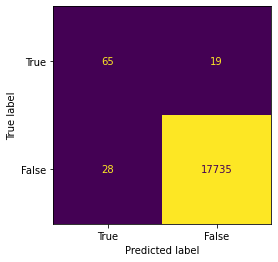

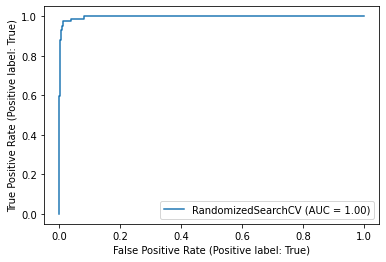

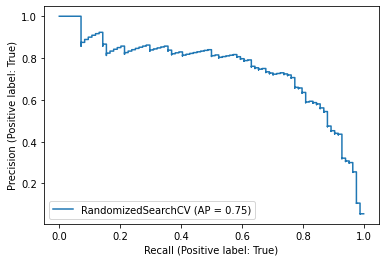

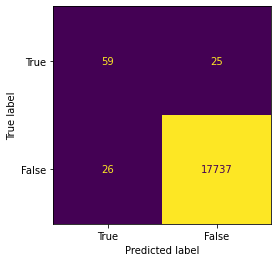

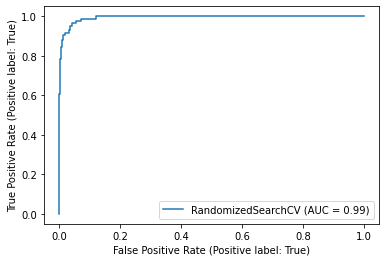

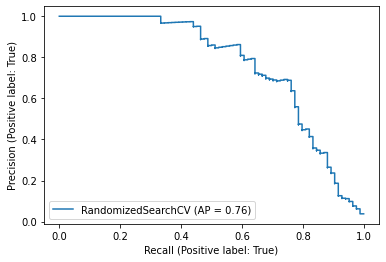

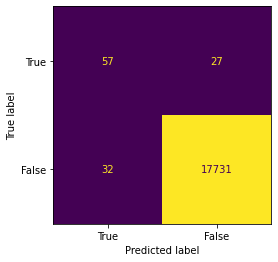

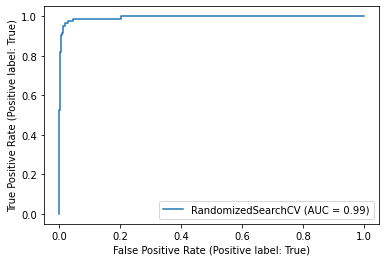

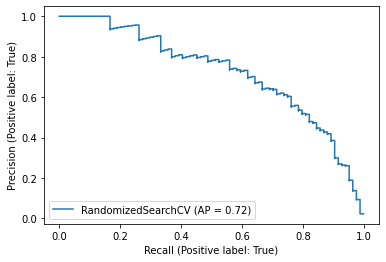

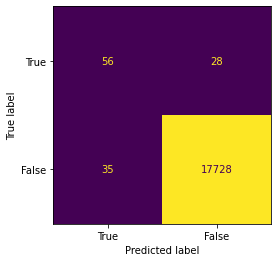

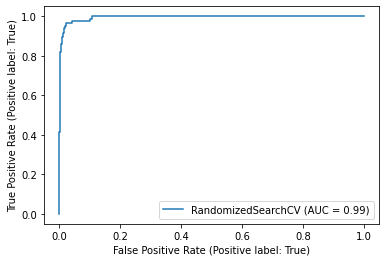

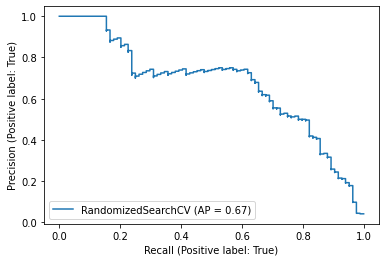

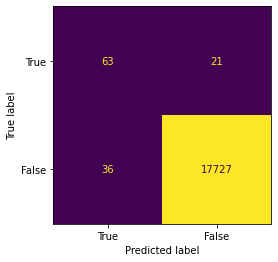

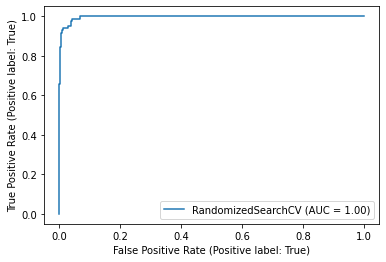

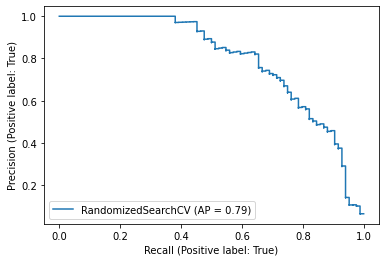

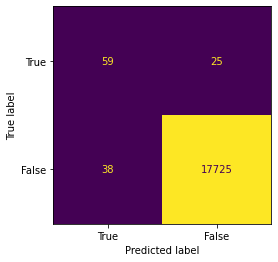

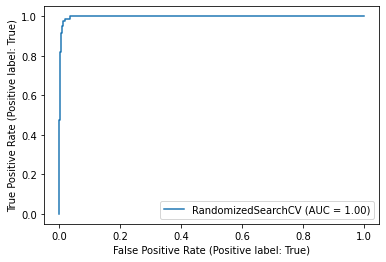

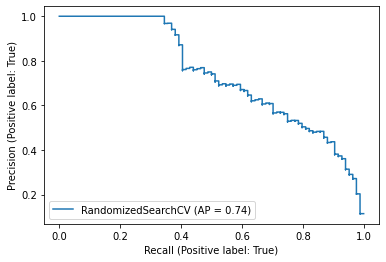

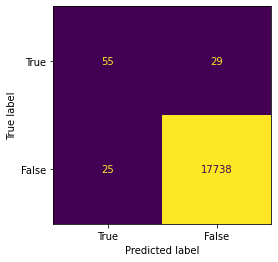

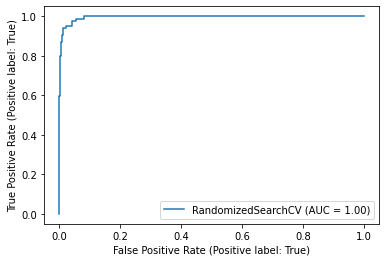

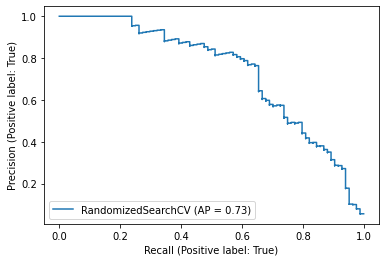

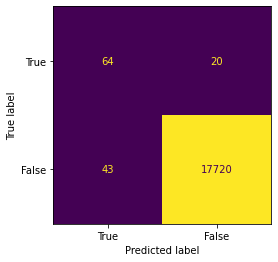

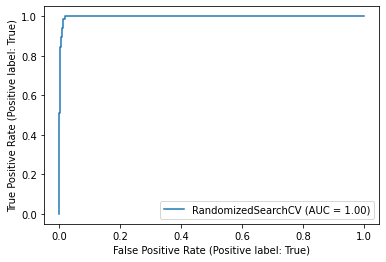

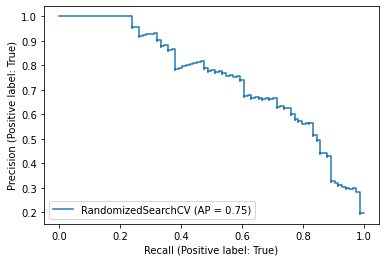

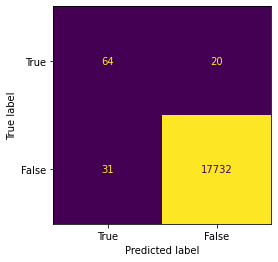

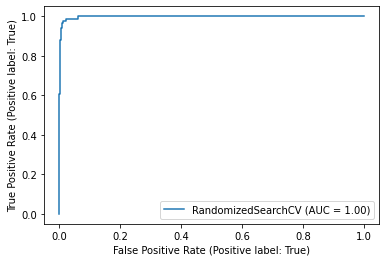

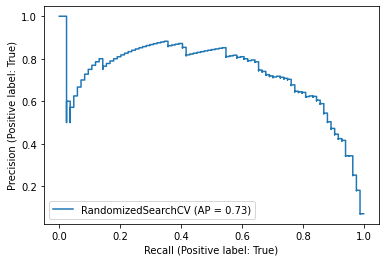

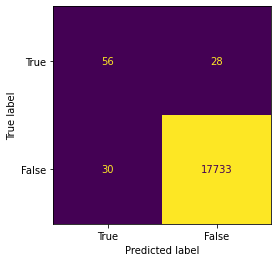

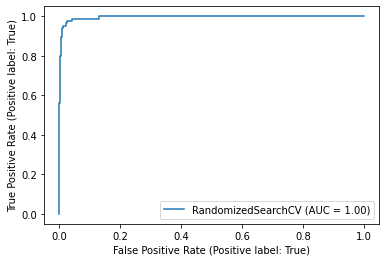

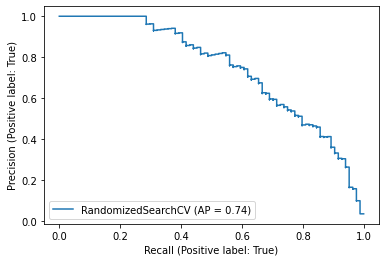

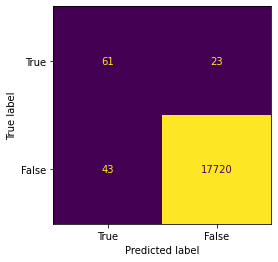

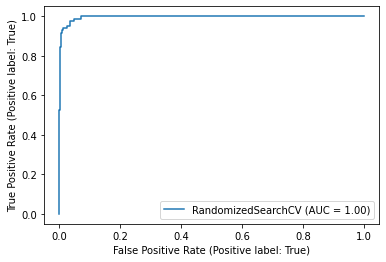

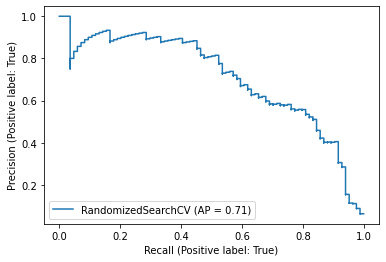

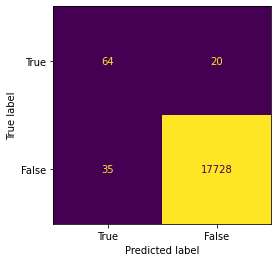

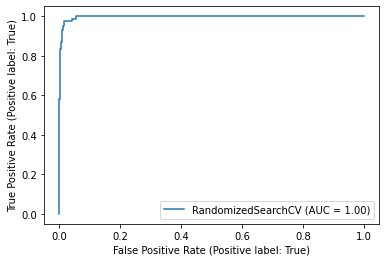

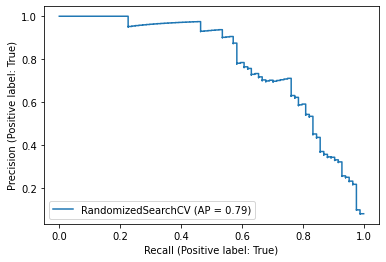

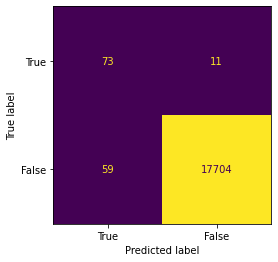

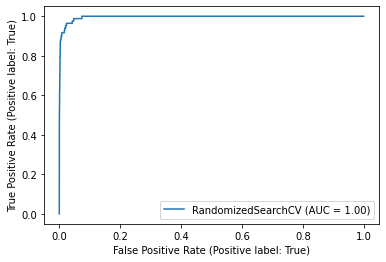

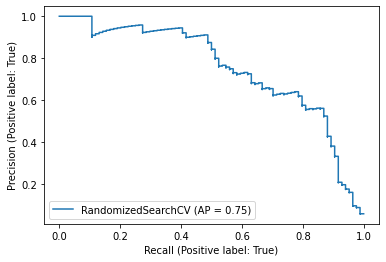

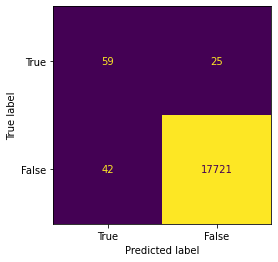

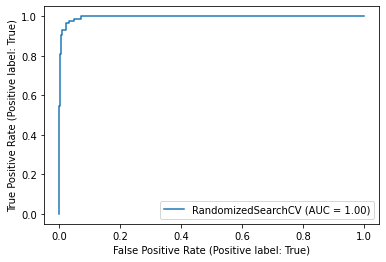

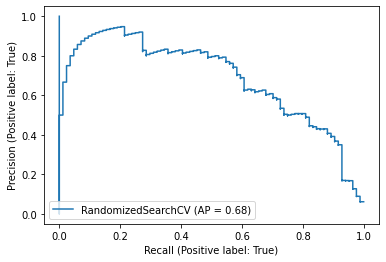

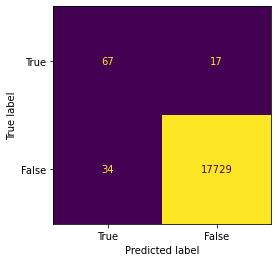

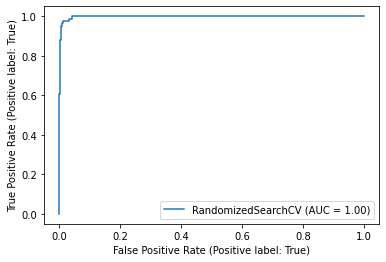

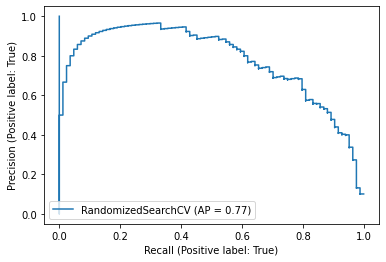

In [9]:
import time
import numpy as np
from imblearn.pipeline import Pipeline 
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import fbeta_score, make_scorer


#Import feature selection stuff
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

# Import the model we are using
import lightgbm as lgb

for i in range(25):

    ftwo_scorer = make_scorer(fbeta_score, beta=2)

    start_time = time.time()
    X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels,
                                                    test_size=0.2,
                                                    stratify=labels)


    LightGBMPipeline = Pipeline(steps = [['smote', SMOTE(sampling_strategy = 0.5, n_jobs=2)],
                                    ['under', RandomUnderSampler()],
                                ['classifier', lgb.LGBMClassifier(n_jobs=2, importance_type='gain')]])

    stratified_kfold = StratifiedKFold(n_splits=10,shuffle=True)

    # define search space
    space = dict()
    space['classifier__num_leaves'] = [11, 16, 21, 26, 31, 36, 41, 46, 51, 56]
    space['classifier__min_data_in_leaf'] =  [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__max_depth'] = [-1, 100, 200, 300, 400, 500, 600, 700, 800, 900]
    space['classifier__learning_rate'] = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9, 1.0]
    space['classifier__max_bin'] = [50, 100, 150, 200, 255, 300, 350, 400, 450, 500]
    spaceEmpty = dict()


    LightGBMSearch = RandomizedSearchCV(estimator = LightGBMPipeline, 
                            param_distributions=space, 
                            n_iter=100, 
                            scoring= ftwo_scorer, 
                            n_jobs=2, 
                            cv = stratified_kfold)

    optimizedLightGBMModel = LightGBMSearch.fit(X_train, y_train)

    elapsed_time = time.time() - start_time

    print(f"Elapsed time to compute best fit: "
      f"{elapsed_time:.3f} seconds")
    cv_score = optimizedLightGBMModel.best_score_
    test_score = optimizedLightGBMModel.score(X_test, y_test)
    print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')
    print('Best Hyperparameters: %s' % optimizedLightGBMModel.best_params_)
    
    #feature importance
    importances = optimizedLightGBMModel.best_estimator_._final_estimator.booster_.feature_importance(importance_type='gain')
    for i,v in enumerate(importances):
        print(v)


    #Display the model performance    
    showModelPerformance(trainedModel = optimizedLightGBMModel, 
                     testFeatures = X_test, 
                     testLabels = y_test)